# base_v3-Copy1.ipynb

Substituting the chwr_linear AF units by logarithmic units.

In [13]:
%cd ../..
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z


In [14]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [15]:
%%cython
from draculab import *

In [16]:
##################################
####### Create the network #######
##################################

# simulation control parameters
t_pres = 20. # number of seconds to hold each set of target lengths
rand_w = False # whether to use random weights in M->C, AF->M

# First the network object, the plant, the list of coordinates
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
P_params = {  'type' : plant_models.bouncy_planar_arm_v3,
          'mass1': 1.,
          'mass2': 1.,
          's_min' : -0.4,
          'p1' : (-0.01, 0.04),
          'p2' : (0.29, 0.03),
          'p3' : (0., 0.05),
          'p5' : (0.01, -0.05),
          'p10': (0.29, 0.03),
          'init_q1': 0., # 0.53496133, # coords of first target
          'init_q2': np.pi/2., # 0.89566479,
          'init_q1p': 0.,
          'init_q2p': 0.,
          'g': 0.0,
          'mu1': 1.,
          'mu2': 1.,
          'l_torque' : 0.01,
          'l_visco' : 0.01,
          'g_e' : 8.,
          'l0_e' : [1.]*6,
          'Ia_gain' : 2.5*np.array([3.,10.,10., 3.,10.,10.]),
          'II_gain' : 2.*np.array([3., 8., 8., 3., 8., 8.]),
          'Ib_gain' : 1.,
          'T_0' : 10.,
          'k_pe_e' : .5, # 4.,
          'k_se_e' : 20., # 6.,
          'b_e' : 5.,
          'g_s' : 0.02,
          'k_pe_s' : 2., 
          'k_se_s' : 2.,
          'g_d' : 0.01,
          'k_pe_d' : .2, #.1,
          'k_se_d' : 1., #2.,
          'b_s' : .5,
          'b_d' : 2.,#3.,
          'l0_s': .7,
          'l0_d': .8,
          'fs' : 0.1,
          'se_II' : 0.5,
          'cd' : 0.5,
          'cs' : 0.5,
          'tau' : 0.1   # ficticious time constant used in create_freqs_steps
           }
net = network(net_params)
P = net.create(1, P_params)
arm = net.plants[P]

# We organize the spinal connections through 4 types of symmetric relations
# these lists are used to set intraspinal connections and test connection matrices
antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# UNIT PARAMETER DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
par_heter = 0.05 # range of heterogeneity as a fraction of the original value
#randz1 = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz6 = lambda : (1. + par_heter*(np.random.rand(6)-0.5))
randz12 = lambda : (1. + par_heter*(np.random.rand(12)-0.5))
randz18 = lambda : (1. + par_heter*(np.random.rand(18)-0.5))
randz36 = lambda : (1. + par_heter*(np.random.rand(36)-0.5))

ACT_params = {'type' : unit_types.act,
              'tau_u' : 10.,
              'gamma' : 2.,
              'g' : 2.,
              'theta' : 2,
              'tau_slow' : 5.,
              'y_min' : 0.2,
              'rst_thr' : 0.1,
              'init_val' : 0. }
spf_sum_min = .4 # value where no corrections are needed anymore
y_min = 1./(1. + np.exp(-ACT_params['g']*(spf_sum_min - ACT_params['theta'])))
ACT_params['y_min'] = y_min

AF_params = {'type' : unit_types.logarithmic,
             'init_val' : [1.69521365e-03, 1.38066930e-04, 8.22826241e-03, 4.57382536e-03,
                           2.63279923e-03, 1.33950962e-03, 3.96717388e-02, 1.76216213e-01,
                           5.42828194e-02, 1.56028196e-02, 6.89968040e-02, 9.08714994e-02,
                           5.11518045e-02, 1.99303055e-01, 2.45623689e-02, 1.86245176e-02,
                           1.86034265e-02, 9.97734455e-02] + [0.00000000e+00, 0.00000000e+00,
                           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                            1.82035549e-03, 1.02861722e-01, 4.72605123e-03, 2.08303105e-04,
                            9.28135655e-03, 4.66304248e-02, 0.00000000e+00, 3.96374006e-02,
                            0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.82790315e-06],
             'tau' : 0.02 * randz36(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             #'tau_slow' : 500., # using a slow value, so init_val is important
             'delay' : 0.1,
             'thresh' : [0.08, 0.24, 0.08, 0.07, 0.11, 0.20,
                         0.07, -.08, 0.34, 0.13, 0.19, 0.05,
                         0.21, -.06, 0.55, 0.30, 0.36, 0.10]*2 }
AL_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.3 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.1 * randz6(),
             'tau' : 0.05 * randz6() }
CE_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : 0.1 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.02 * randz6(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : 6.,
             'custom_inp_del' : 15,
             'integ_amp' : .5,
             'integ_decay' : 0.1,
             'adapt_amp' : 8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 2. }
CI_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : .5 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.5 * randz6(), #0.02 * randz6(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : 6.,
             'custom_inp_del' : 15,
             'integ_amp' : .5,
             'integ_decay' : 0.1,
             'adapt_amp' : 8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 2. }
M_params = {'type' : unit_types.gated_out_norm_am_sig,
            'thresh' : 0. * randz12(),
            'slope' : 3. * randz12(),
            'init_val' : 0.2 * randz12(),
            'delay' : 0.2,
            'tau_fast': 0.1,
            'tau_mid': 1.,
            'tau_slow' : 4.,
            'tau' : 0.01 * randz12(),
            'p0_inp' : 0.0,
            'des_out_w_abs_sum' : 1. }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : [3.96717388e-02, 1.76216213e-01,  # AF time averages
       5.42828194e-02, 1.56028196e-02, 6.89968040e-02, 9.08714994e-02,
       5.11518045e-02, 1.99303055e-01, 2.45623689e-02, 1.86245176e-02,
       1.86034265e-02, 9.97734455e-02],
#            [0.03, 0.14, 0., 0., 0.0, 0.04,  # AF target averages
#              0.06, 0.21, 0., 0.0, 0.0, 0.08]
             'slope' : 8.*np.array([3.47, 2.29, 4.0, 4.0,  3.71, 2.83,
                                 3.08, 1.89, 4.0, 3.91, 3.58, 2.20]),
             'init_val' : 0.2 * randz12(),
             'tau' : 0.03 * randz12() } 
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'tau_fast' : 0.02,
             'tau_mid' : 0.1,
             'function' : lambda t: None }
SP_CHG_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.3,
              'slope' : 9.,
              'init_val' : 0.1,
              'tau' : 0.01 }
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.4 * randz12(),
              'slope' : 6. * randz12(),
              'init_val' : 0.3 * randz12(),
              'tau_fast': 0.05,
              'tau_mid': 0.5,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz12() }
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTION DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# ACT to CE,CI ------------------------------------------------
ACT__CE_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CE_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
ACT__CI_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CI_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
# AF to CE, CI --------------------------------------------------
AF__CE_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CE_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'normalize' : True,
              'w_sum' : .3,
              'lrate' : 5.,
              'extra_steps' : 1,
              'init_w' : 0.05 }
AF__CI_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CI_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'normalize' : True,
              'w_sum' : .3,
              'lrate' : 5.,
              'extra_steps' : 1,
              'init_w' : 0.05 }
# AF to M ------------------------------------------------
## Creating a test matrix
if not rand_w:
    AF_M = np.zeros((36, 12)) # rows are source, columns target
    for src in range(36):
        for trg in range(12):
            src_pop = src%6 #src's population
            trg_pop = trg%6 #trg's population
            if src%18 < 6: # if the afferent is tension, don't reverse signs
                sig = 1
            else:
                sig = -1
            if src > 17: sig = -sig # if 'negative' afferent reverse sign
            for pair in antagonists:
                if pair == (src_pop, trg_pop):
                    AF_M[src, trg] = sig*0.2
                    break
            else: 
                for pair in part_antag:
                    if pair == (src_pop, trg_pop):
                        AF_M[src, trg] = sig*0.1
                        break
                else: 
                    for pair in synergists:
                        if pair == (src_pop, trg_pop):
                            AF_M[src, trg] = sig*-0.2
                            break
                    else: 
                        for pair in synergists:
                            if pair == (src_pop, trg_pop):
                                AF_M[src, trg] = sig*-0.2
                                break
                        else: 
                            for pair in part_syne:
                                if pair == (src_pop, trg_pop):
                                    AF_M[src, trg] = sig*-0.1
                                    break
                            else:
                                if src_pop == trg_pop:
                                    AF_M[src, trg] = sig*-0.3
else:
    AF_M = 0.2*(np.random.random((36,12)) - 0.5) # random initial connections!!!!!
AF__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
AF__M_syn = {'type' : synapse_types.gated_diff_inp_sel,
            'aff_port' : 0,
            'error_port' : 1,
            'normalize' : False,
            'w_sum' : 3.,
            'inp_ports' : 0, # afferent for out_norm_am_sig
            'input_type' : 'pred', # if using inp_corr
            'lrate' : 0., #5.,
            'extra_steps' : None, # placeholder value; filled below,
            'init_w' : AF_M.flatten() } 
# AF to SF ------------------------------------------------
AF__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
AF__SF_syn = {'type' : synapse_types.static,
             'init_w' : 1. }
# AL to P ------------------------------------------------
AL__P_conn = {'inp_ports' : list(range(6)),
             'delays': 0.01 }
AL__P_syn = {'type': synapse_types.static,
            'init_w' : 1. }
# CE, CI to AL ----------------------------------------------
CE__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__AL_syn = {'type' : synapse_types.static,
              'init_w' : [1., 1., 1., 1., 1., 1.] }
CI__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__AL_syn = {'type' : synapse_types.static,
              'init_w' : -1. }
# CE,CI to CE,CI  ------------------------------------------------
CE__CI_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__CE_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__CI_syn = {'type' : synapse_types.static,
              'inp_ports' : 1,
              'init_w' : 1. }
CI__CE_syn = {'type' : synapse_types.static, #static, #corr_inh,
              'inp_ports' : 1,
              'lrate' : .0,
              'des_act' : 0.5,
              'init_w' : -2. }
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn_antag = {'type' : synapse_types.bcm, #oja, #bcm, #corr_inh,
                  'inp_ports': 1,
                  'init_w' : 2., #1.
                  'lrate' : 1.,
                  'des_act' : 0.5 }
C__C_syn_p_antag = {'type' : synapse_types.bcm, #bcm,
                  'inp_ports': 1,
                  'init_w' : .5, #.4
                  'lrate' : 1.,
                  'des_act' : 0.5 }
C__C_syn_syne = {'type' : synapse_types.static,
                 'inp_ports': 1,
                 'lrate' : 1.,
                 'init_w' : .5 }
C__C_syn_p_syne = {'type' : synapse_types.static,
                   'inp_ports': 1,
                   'lrate' : 1.,
                   'init_w' : 0.2 }
# M to CE,CI ----------------------------------------------
# creating a test matrix
if not rand_w:
    M_CE = np.array(
        [[ 0.2,  0.1, -0.1, -0.2,  0.1, -0.1],
         [ 0.1,  0.2, -0.2, -0.1,  0.1,  0.0],
         [-0.1, -0.2,  0.2,  0.1,  0.0,  0.0],
         [-0.2, -0.1,  0.1, -0.2, -0.1,  0.1],
         [ 0.1,  0.0,  0.0, -0.1,  0.3, -0.2],
         [-0.1,  0.0,  0.0,  0.1, -0.2,  0.3],
         [ 0.2,  0.1, -0.1, -0.2,  0.1, -0.1],
         [ 0.1,  0.2, -0.2, -0.1,  0.1,  0.0],
         [-0.1, -0.2,  0.2,  0.1,  0.0,  0.0],
         [-0.2, -0.1,  0.1, -0.2, -0.1,  0.1],
         [ 0.1,  0.0,  0.0, -0.1,  0.3, -0.2],
         [-0.1,  0.0,  0.0,  0.1, -0.2,  0.3]])
    M_CI = -M_CE 
else:
    M_CE = 0.4*(np.random.random((6,12)) - 0.5) # random initial connections!!!!!
    M_CI = 0.4*(np.random.random((6,12)) - 0.5) # random initial connections!!!!!
M__CE_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CE_syn = {'type' : synapse_types.gated_rga,
             'inp_ports' : 0,
             'lrate' : 0., #20.,
             'w_sum' : 2.,
             'init_w' : M_CE.flatten() } # flatten column-mayor style
M__CI_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CI_syn = {'type' : synapse_types.gated_rga,
             'inp_ports' : 0,
             'lrate' : 0., #20,
             'w_sum' : 2.5,
             'init_w' : M_CI.flatten() }
# P to AF  ---------------------------------------------------
idx_aff = np.arange(22,40) # indexes for afferent output in the arm
P__AF_conn = {'port_map' : [[(p,0)] for p in idx_aff],
             'delays' : 0.02 }
Pe__AF_syn = {'type' : synapse_types.static,
              'init_w' : [1.] * 18 } 
Pi__AF_syn = {'type' : synapse_types.static,
            'init_w' :  [-1.] * 18  }
# SF, SP to SPF ------------------------------------------------
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SP to SP_CHG ------------------------------------------------
SP__SP_CHG_conn = {'rule' : 'all_to_all',
                    'delay' : 0.01}
SP__SP_CHG_syn = {'type' : synapse_types.chg,
                  'init_w' : 0.,
                  'lrate' : 20. }
# SP_CHG to CE, CI ------------------------------------------------
SP_CHG__CE_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__CE_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
SP_CHG__CI_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__CI_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
# SP_CHG to ACT ------------------------------------------------
SP_CHG__ACT_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__ACT_syn = {'type' : synapse_types.static,
                  'inp_ports' : 1,
                  'init_w' : 1. }
# SP_CHG to M ------------------------------------------------
SP_CHG__M_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__M_syn = {'type' : synapse_types.static,
                  'inp_ports' : 2,
                  'init_w' : 1. }
# SPF to ACT ------------------------------------------------
SPF__ACT_conn = {'rule' : "all_to_all",
                 'delay' : 0.02 }
SPF__ACT_syn = {'type' : synapse_types.static,
                'inp_ports' : 0,
                'init_w' : 1. }
# SPF to M  ------------------------------------------------
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.01 }
SPF__M_syn = {'type' : synapse_types.static, #synapse_types.inp_corr,
              'inp_ports' : 1,
              'lrate' : 0.,
              'input_type' : 'error', # if using inp_corr
              'init_w' : 1. }

#*************************************************************
# Setting the right delay for AF-->M
f = 1. # going to estimate the extra delay of error inputs wrt afferent inputs at M
w = 2.*np.pi*f
sf_del = np.arctan(np.mean(SF_params['tau'])*w)/w
spf_del = np.arctan(np.mean(SPF_params['tau'])*w)/w
delay = spf_del + sf_del + AF__SF_conn['delay'] + SFe__SPF_conn['delay']
steps = int(round(delay/net.min_delay))
AF_params['delay'] = AF_params['delay'] + (
                     net_params['min_delay'] * (np.ceil(delay/net_params['min_delay']) + 1))
AF__M_syn['extra_steps'] = steps
#*************************************************************
# utilitiy function for the M-->C delays used in the rga rule
def approx_del(f):
    """ Returns an estimate fo the optimal delay for rga learning.
    
        We assume that the important loop for the learning rule in the C units
        is the one going through C-AL-P-AF-M-C.
        We also assume the delays to/from CI are the same as the ones for CE.
        
        Args:
            f : oscillation frequency of E-I pair in C, in Hertz
        Returns:
            2-tuple : (time_del, del_steps)
            time_del : A float with the time delay.
            del_steps : time delay as integer number of min_del steps.
    """
    w = 2.*np.pi*f
    al_del = np.arctan(np.mean(AL_params['tau'])*w)/w
    p_del = np.arctan(np.mean(P_params['tau'])*w)/w
    af_del = np.arctan(np.mean(AF_params['tau'])*w)/w
    m_del = np.arctan(np.mean(M_params['tau'])*w)/w
    D = [CE__AL_conn['delay'], AL__P_conn['delays'], np.mean(P__AF_conn['delays']),
         AF__M_conn['delay'], M__CE_conn['delay'] ]
    time_del = al_del + p_del + af_del + m_del + sum(D)
    del_steps = int(np.ceil(time_del/net_params['min_delay']))
    time_del = del_steps*net_params['min_delay']
    del_steps -= 1 # because this is an index, and indexes start at 0
    return time_del, del_steps
# Approximating the delays for the rga rule
time_del, del_steps = approx_del(0.65) #0.65 is approximate CE/CI frequency observed in simulations
CE_params['delay'] = time_del
CI_params['delay'] = time_del
M_params['delay'] = time_del
CE_params['custom_inp_del'] = del_steps
CI_params['custom_inp_del'] = del_steps
#*************************************************************

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CREATING UNITS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ACT = net.create(1, ACT_params)
AF = net.create(36, AF_params)
AL = net.create(6, AL_params)
CE = net.create(6, CE_params)
CI = net.create(6, CI_params)
M = net.create(12, M_params)
SF = net.create(12, SF_params)
SP = net.create(12, SP_params)
SP_CHG = net.create(1, SP_CHG_params)
SPF = net.create(12, SPF_params)

# SET THE PATTERNS IN SP -----------------------------------------------------
# list with hand coordinates [x,y] (meters)
hand_coords = [[0.3, 0.45], 
               [0.35, 0.4],
               [0.4, 0.35],
               [0.35, 0.3],
               [0.3, 0.25],
               [0.25, 0.3],
               [0.2, 0.35],
               [0.25, 0.4]]
               #[-0.1, 0.3],
               #[-0.1, 0.35]] # experimental extra coordinates
# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to Ia, II afferent activity.
### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE THE POSITIVE Ia AND II ###
par = net.plants[P].m_params
# steady state tensions in the static and dynamic bag fibers (no gamma inputs)
Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
         par['k_pe_s']*(m_lengths - par['l0_s']))
Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
         par['k_pe_d']*(m_lengths - par['l0_d']))
# steady state afferent outputs (no gamma inputs)
Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
Ia_ss *= par['Ia_gain']
II_ss *= par['II_gain']
I_ss = np.concatenate((Ia_ss, II_ss), axis=1)
# Next transformation is through the logarithmic afferent units
#Pe__AF_Ia_ws = np.array(Pe__AF_syn['init_w'][6:12])
#Pe__AF_II_ws = np.array(Pe__AF_syn['init_w'][12:18])
Pe__AF_ws = np.array(Pe__AF_syn['init_w'][6:18])
AF_thr = np.array([net.units[u].thresh for u in AF[6:18]])
AF_Ia_II = np.log(1. + np.maximum(I_ss*Pe__AF_ws - AF_thr, 0.))
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# Next is from AF to SF
SF_arg = AF__SF_syn['init_w']*AF_Ia_II
SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
# now we set the values in SP
m_idxs = np.random.randint(len(hand_coords), size=1000) # index of target lengths
m_idxs[0] = 0 # for testing
def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]
for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# tracking units
M_CE_track = net.create(len(M), track_params) # to track weights from M to CE
#M_CI_track = net.create(len(M), track_params) # to track weights from M to CI
AF_M0_track = net.create(18, track_params) # to track half the weights from AF to M0

xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
up_track = net.create(1, track_params) # to track the derivative of CE0
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for CE0 at port 0
spj_track = net.create(1, track_params) # input derivative for MX--CE0

ipx_track = net.create(12, track_params) # x coordinates of insertion points
ipy_track = net.create(12, track_params) # y coordinates of insertion points

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTING
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# from M to CE
net.connect(M, CE, M__CE_conn, M__CE_syn)
# from M to CI
net.connect(M, CI, M__CI_conn, M__CI_syn)
# from CE to AL
net.connect(CE, AL, CE__AL_conn, CE__AL_syn)
# from CI to AL
net.connect(CI, AL, CI__AL_conn, CI__AL_syn)
# from AL to P
net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
# from P to AF
net.set_plant_outputs(P, AF[0:18], P__AF_conn, Pe__AF_syn)
net.set_plant_outputs(P, AF[18:36], P__AF_conn, Pi__AF_syn)
# from AF to SF. Only positive Ia and II are selected
net.connect(AF[6:18], SF, AF__SF_conn, AF__SF_syn)
# from AF to M
net.connect(AF, M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
# from AF to CE,CI
#net.connect(AF, CE, AF__CE_conn, AF__CE_syn)
#net.connect(AF, CI, AF__CI_conn, AF__CI_syn)
# from SF, SP to SPF
net.connect(SF, SPF, SFe__SPF_conn, SFe__SPF_syn) # F-P
#net.connect(SF, SPF, SFi__SPF_conn, SFi__SPF_syn)  # P-F
net.connect(SP, SPF, SPi__SPF_conn, SPi__SPF_syn) # F-P
#net.connect(SP, SPF, SPe__SPF_conn, SPe__SPF_syn)  # P-F
# from SPF to M
net.connect(SPF, M, SPF__M_conn, SPF__M_syn) # should be after AF-->M
# from SPF to ACT
net.connect(SPF, ACT, SPF__ACT_conn, SPF__ACT_syn)
# from SP to SP_CHG
net.connect(SP, SP_CHG, SP__SP_CHG_conn, SP__SP_CHG_syn)
# from SP_CHG to CE,CI
net.connect(SP_CHG, CE, SP_CHG__CE_conn, SP_CHG__CE_syn)
net.connect(SP_CHG, CI, SP_CHG__CI_conn, SP_CHG__CI_syn)
# from SP_CHG to M
net.connect(SP_CHG, M, SP_CHG__M_conn, SP_CHG__M_syn)
# from SP_CHG to ACT
net.connect(SP_CHG, ACT, SP_CHG__ACT_conn, SP_CHG__ACT_syn)
# from ACT to CE, CI
net.connect(ACT, CE, ACT__CE_conn, ACT__CE_syn)
net.connect(ACT, CI, ACT__CI_conn, ACT__CI_syn)
# intraspinal connections 
# from CE to CI, and CI to CE
net.connect(CE, CI, CE__CI_conn, CE__CI_syn)
net.connect(CI, CE, CI__CE_conn, CI__CE_syn)
# agonists and antagonists
EE_syn_dicts = [C__C_syn_syne, C__C_syn_p_syne]
EI_syn_dicts = [C__C_syn_antag, C__C_syn_p_antag]
EE_pair_lists = [synergists, part_syne] # order should match list above
EI_pair_lists = [antagonists, part_antag] # order should match list above
for pair_list, syn_dict in zip(EE_pair_lists, EE_syn_dicts):
    firsts = [CE[p[0]] for p in pair_list]
    seconds = [CE[p[1]] for p in pair_list]
    net.connect(firsts, seconds, C__C_conn, syn_dict)
    net.connect(seconds, firsts, C__C_conn, syn_dict)
for pair_list, syn_dict in zip(EI_pair_lists, EI_syn_dicts):
    firsts = [CE[p[0]] for p in pair_list] + [CE[p[1]] for p in pair_list]
    seconds = [CI[p[1]] for p in pair_list] + [CI[p[0]] for p in pair_list]
    net.connect(firsts, seconds, C__C_conn, syn_dict)

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This assumes the first connections to C are M-->C
def M_CE0_fun(idx):
    """ Creates a function to track a weight from M to CE0. """
    return lambda t: net.syns[CE[0]][idx].w
for idx in range(len(M)):
    net.units[M_CE_track[idx]].set_function(M_CE0_fun(idx))
# This assumes the first connections to M are AF-->M    
def AF_M0_fun(idx):
    """ Creates a function to track a weight from AF to M0. """
    return lambda t: net.syns[M[0]][idx].w
for idx in range(18):
    net.units[AF_M0_track[idx]].set_function(AF_M0_fun(idx))

# SETTING TRACKING OF PLASTICITY FACTORS FOR MX-->CE0
X = 0 # index of the M unit we'll monitor

net.units[xp_track[0]].set_function(lambda t: net.units[CE[0]].del_avg_inp_deriv_mp[1])
po_de = net.units[CE[0]].custom_inp_del
net.units[up_track[0]].set_function(lambda t: net.units[CE[0]].get_lpf_fast(po_de) - 
                                    net.units[CE[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[CE[0]].avg_inp_deriv_mp[0])
ds = net.syns[CE[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[M[X]].get_lpf_fast(ds) - 
                                     net.units[M[X]].get_lpf_mid(ds))
# TRACKING OF INSERTION POINTS (for the arm animation)
# make the source units track the tensions
def create_xtracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][0]
def create_ytracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][1]
for idx, uid in enumerate(ipx_track):
    net.units[uid].set_function(create_xtracker(P, idx))
for idx, uid in enumerate(ipy_track):
    net.units[uid].set_function(create_ytracker(P, idx))

In [ ]:
start_time = time.time()
times, data, plant_data  = net.flat_run(2000.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

Searching base parameters...
* Decreasing k_pe_e, k_se_e. >>> Arm bounces from one extreme position to the next.
* Changing C__C_syn_antag, C__C_syn_p_antag 'type' from bcm to oja. Still similar behavior.
* Changing C__C_syn_antag, C__C_syn_p_antag 'type' from oja to static with weights 20, 10 respectively.
* Increasing b_e from 5 to 50.
* Setting k_pe_e=4, k_se_e=6, b_e=10.
* TESTING `gated_diff_inp_sel` SYNAPSES IN AF__M CONNECTIONS.
* Changed tau_fast and tau_mid in AF. Currently 0.1 and 1.0 respectively
* Restored BCM C__C connections.
* Changed tau_fast from 0.01 to 0.1, and tau_mid from 0.05 to 1.0 in CE,CI, and M, because the differentiation was too fast. For M I also moved tau_slow from 2 ro 4. For SPF tau_fast went from 0.005 to 0.05, and tau_mid from 0.05 to 0.5. Also, things seemed unstable, so I changed mu1 and mu2 from 0.01 to 0.1 in arm_params.
* Disconnected AF__CE/I connections. Some reaching is starting to take place.
* Changed k_se_e from 6 to 20, k_pe_e from 4 to 8.
* Sent mu1 and mu2 back to 0.01 to test the effect.
* Commented out the weight normalization lines in the source code of the gated_rga synapse. The arm got stuck, so I reintroduced the normalization.
* Changed des_out_w_abs_sum from 1 to 2 in CE and CI.
* Following the idea of making the force production more linear, I changed k_pe_e from 6? to .5, k_se_e was left at 20., and b_e went from 10 to 5.
* Set lrate to 5 in AF__M (normalize is False), and from 50 to 20 in M__C.
* Changed friction from .1 to 1, g_e from 10 to 8
* Changed init_w from -1.5 to -2 in CI__CE
* Changed init_w from 1 to 2 in C__C synergists
---
* Have a new M__C initialization. Set lrate from 5 to 0 for M__CE/CI.
* Set a new AF__M initialization. lrate was changed from 5 to 0.
* Changed init_w in SPF__M from 2 to 1. 
* Changed all C__C connections to the values in base_v3ta_bp

[0.16944323 0.03612844 0.08459227 0.08001712 0.107933   0.013567
 0.32488615 0.02538577 0.07825037 0.06888526 0.19672973 0.00274706]
[0.08610005 0.01896156 0.04094693 0.03907513 0.05560744 0.00672312
 0.16509833 0.01332657 0.03789776 0.03361524 0.10133556 0.00136092]


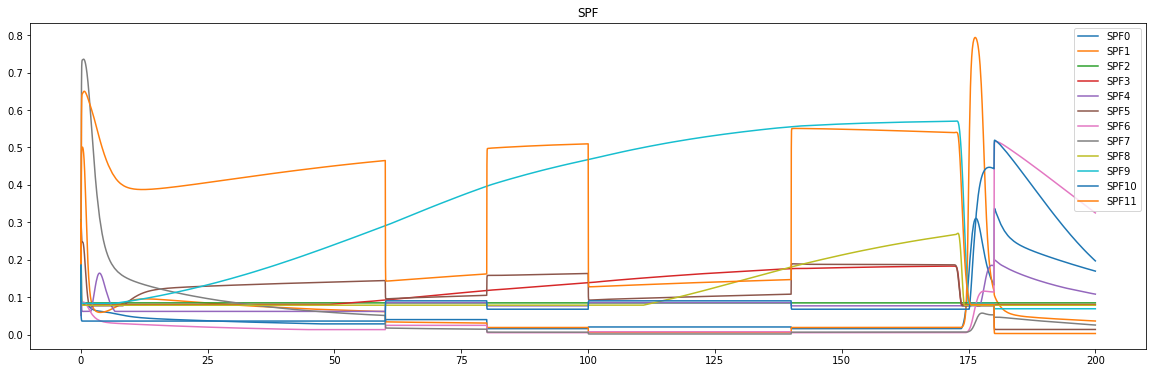

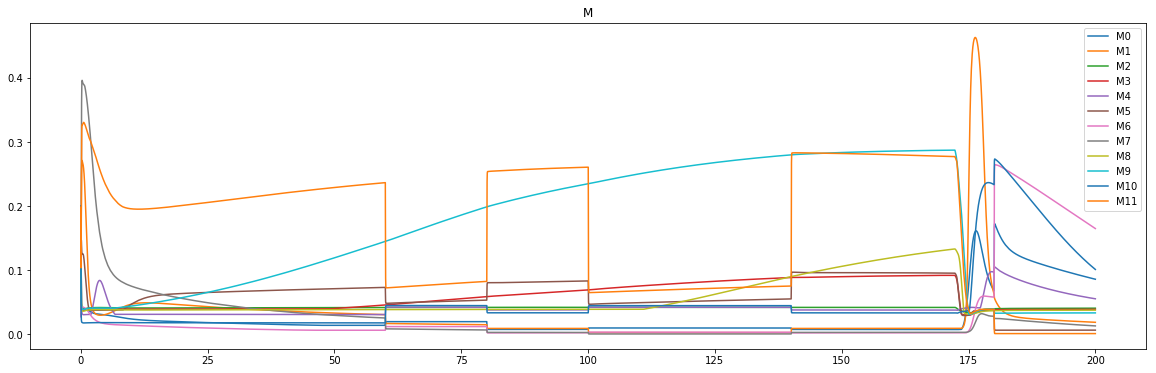

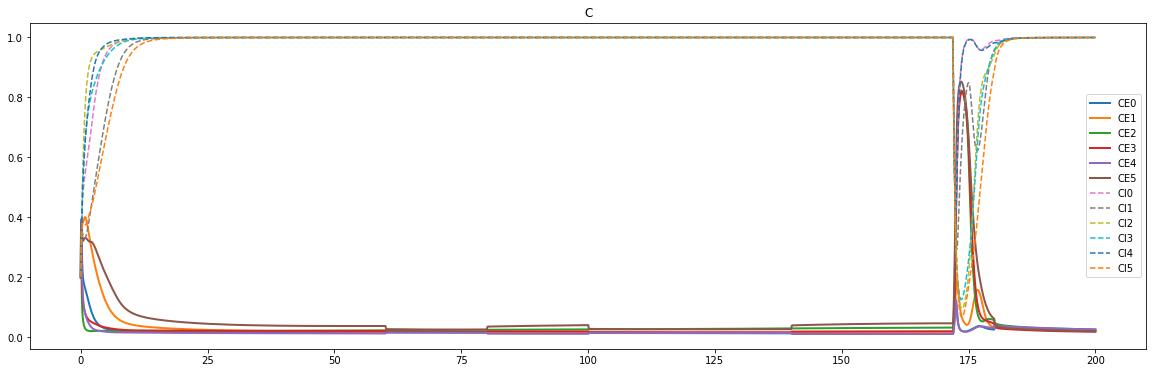

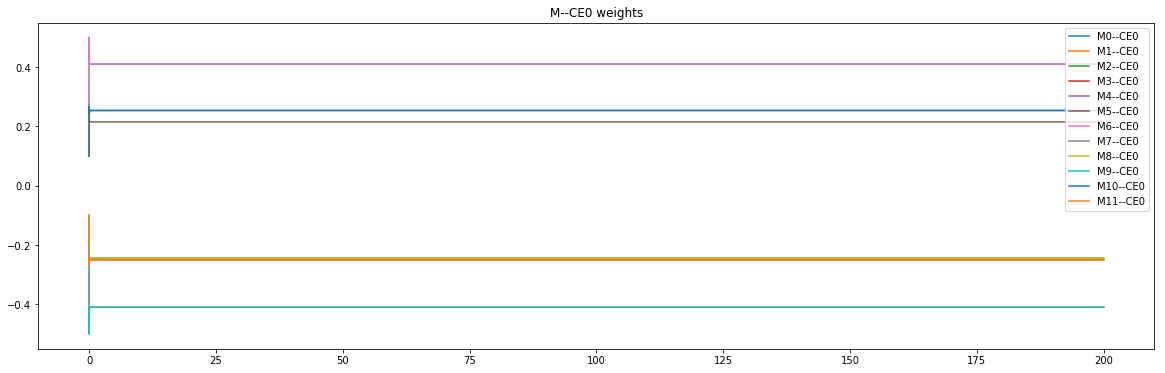

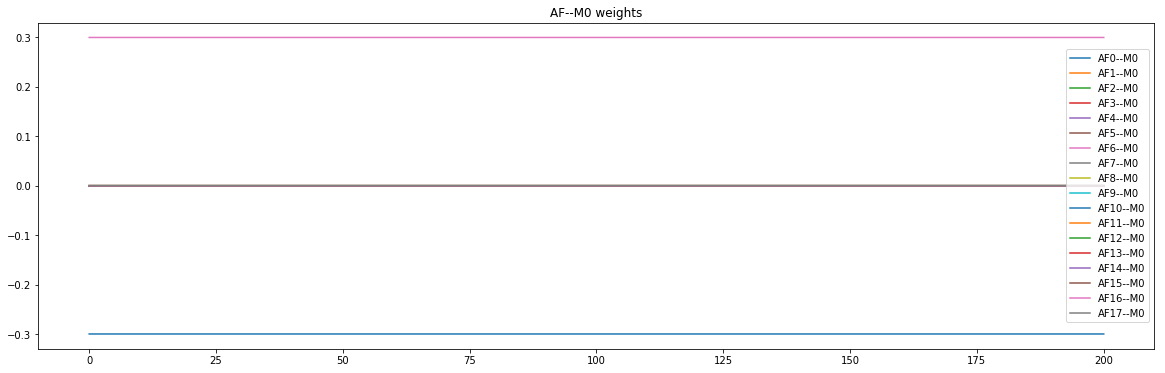

In [7]:
arm_activs = plant_data[P]
# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE])
CI_data = np.array(data[CI])
plt.plot(times, CE_data.transpose(), linewidth=2)
plt.plot(times, CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

# M--CE0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_CE_track])
plt.plot(times, w_track_data.transpose())
M_CE0_legends = ['M'+str(i)+'--CE0' for i in range(len(M_CE_track))]
plt.legend(M_CE0_legends)
plt.title('M--CE0 weights')

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[AF_M0_track])
plt.plot(times, w_track_data2.transpose())
AF_M0_legends = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track))]
plt.legend(AF_M0_legends)
plt.title('AF--M0 weights')

plt.show()

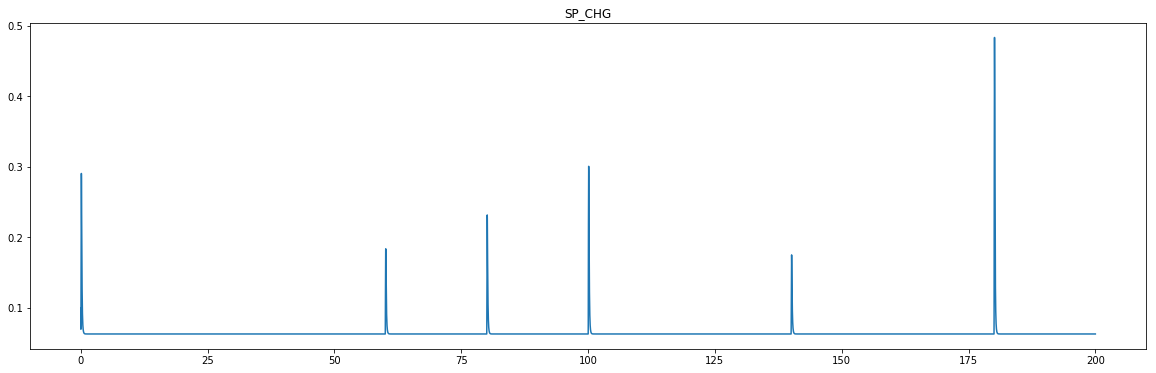

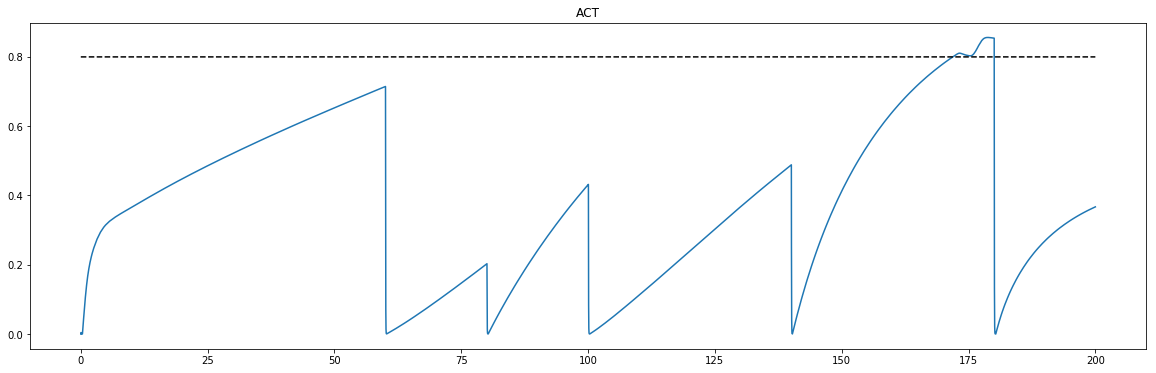

In [8]:
chg_fig = plt.figure(figsize=fs)
chg_data = np.array(data[SP_CHG])[0]
plt.plot(times, chg_data)
plt.title('SP_CHG')

act_fig = plt.figure(figsize=fs)
act_data = np.array(data[ACT])[0]
plt.plot(times, act_data)
plt.plot(times, 0.8*np.ones_like(times), 'k--')

plt.title('ACT')
plt.show()

shoulder angle: 0.391353, shoulder vel: 0.904967
AFe_data:
[9.38724727e-323 9.38724727e-323 9.38724727e-323 9.38724727e-323
 9.88131292e-323 9.88131292e-323 3.50677725e-002 8.86758890e-002
 9.88131292e-323 9.38724727e-323 1.24305003e-002 9.38724727e-323
 7.17996126e-002 1.45176858e-001 9.88131292e-323 9.88131292e-323
 2.17590713e-002 9.88131292e-323]
AFi_data:
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 9.88131292e-323 6.51078529e-002
 9.38724727e-323 9.88131292e-323 9.88131292e-323 9.38724727e-323
 0.00000000e+000 9.38724727e-323 0.00000000e+000 0.00000000e+000
 0.00000000e+000 9.88131292e-323]


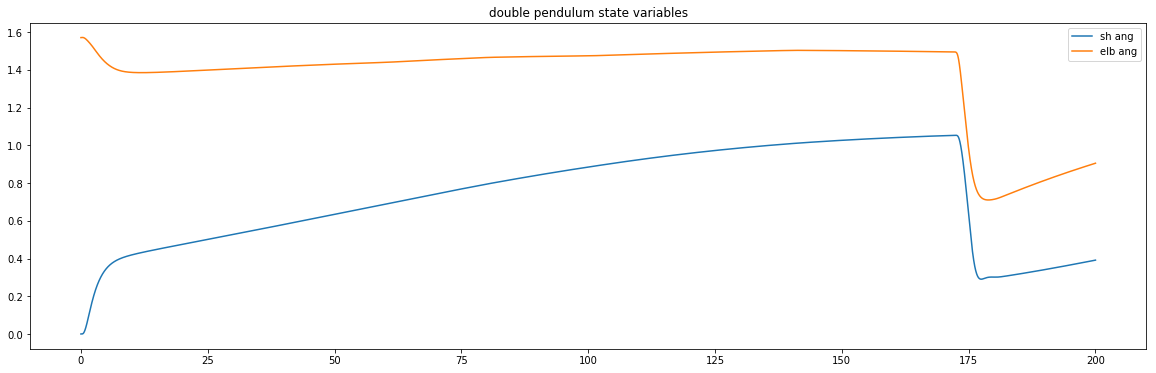

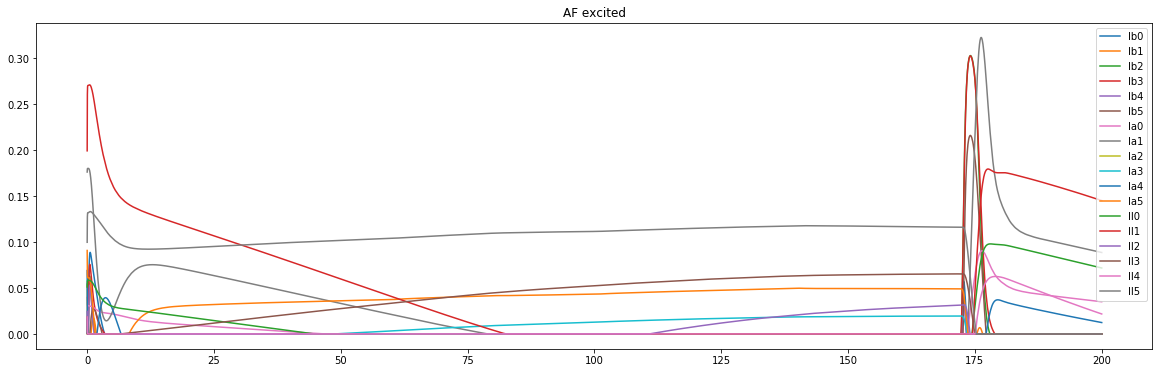

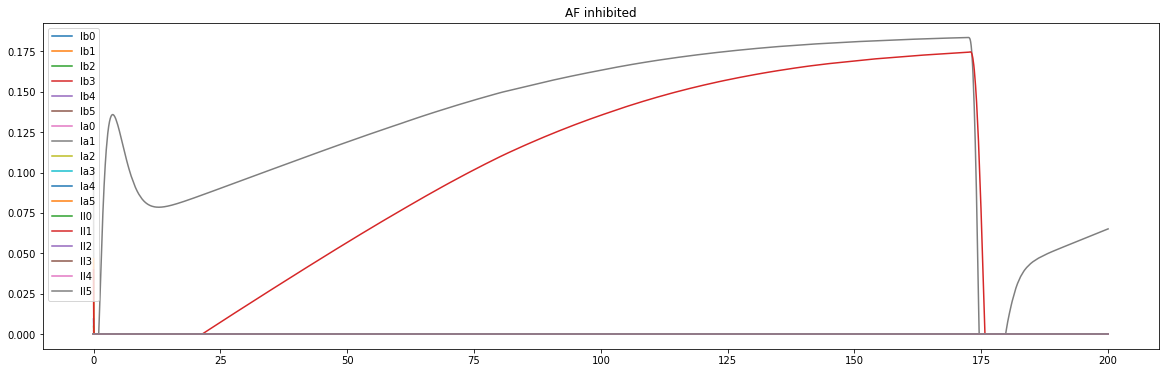

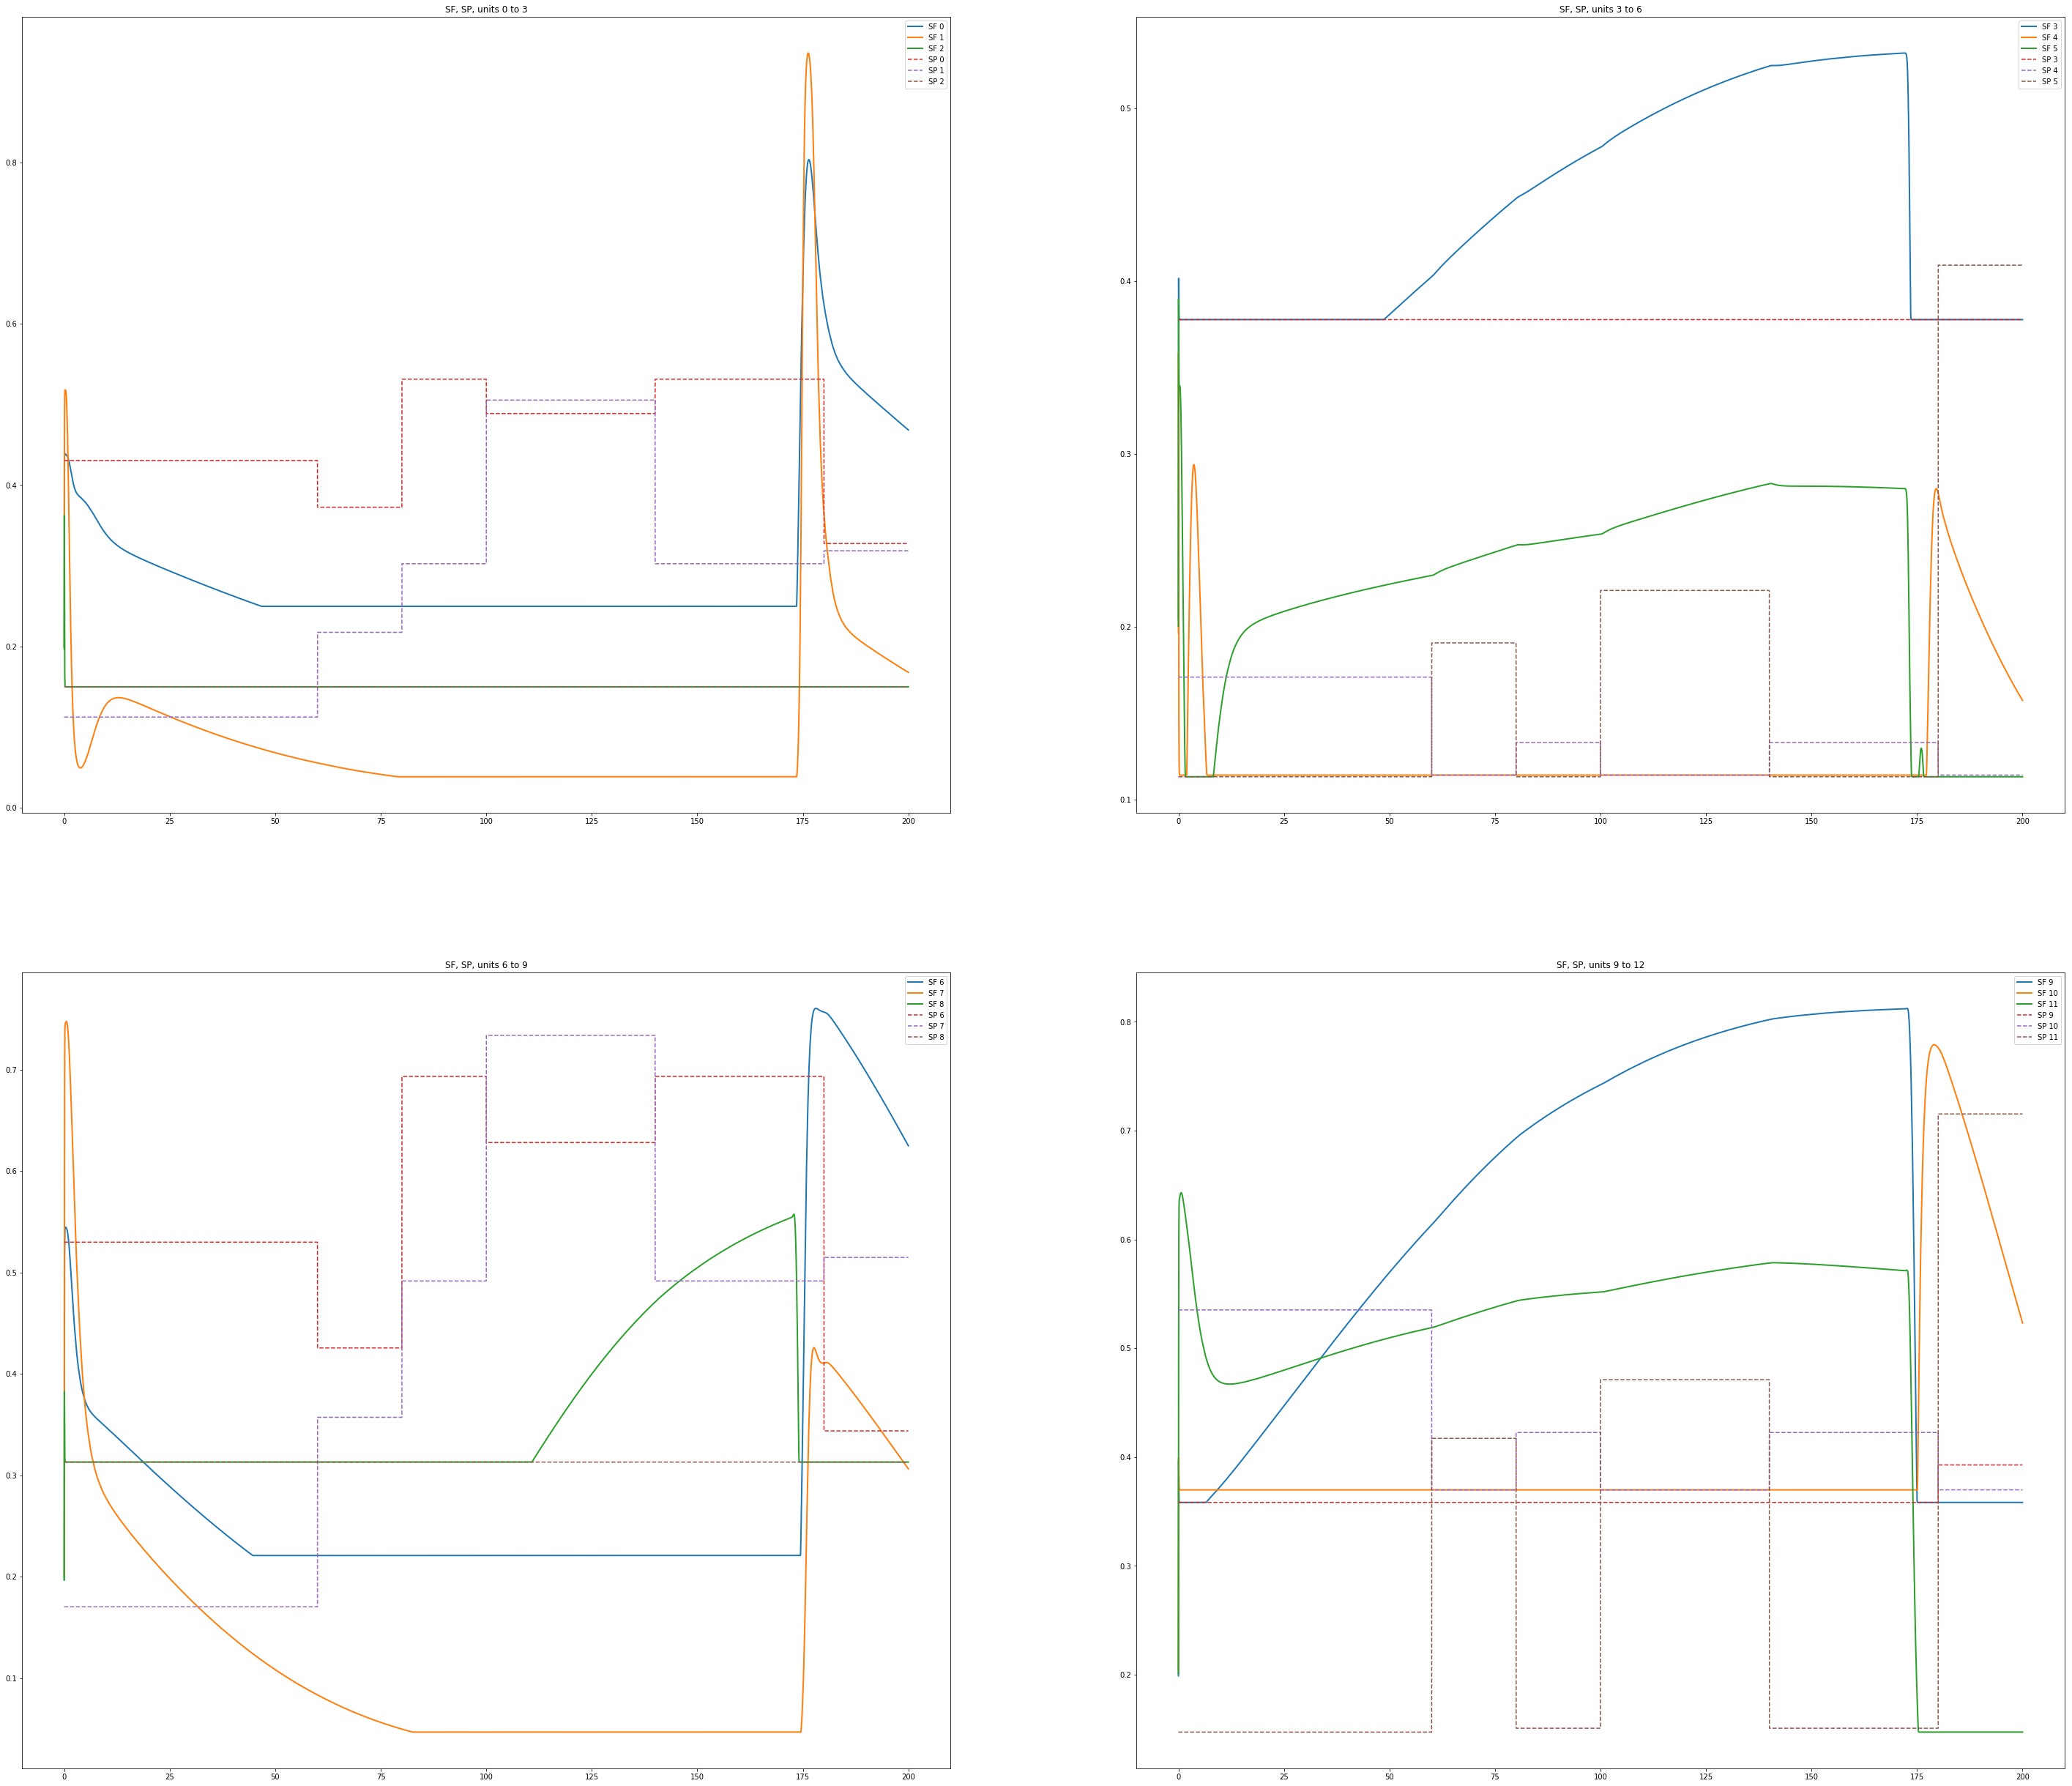

SF = 
[0.4683156  0.16761929 0.149688   0.37770748 0.15745051 0.11331374
 0.62489861 0.30639848 0.31302909 0.35834032 0.52325908 0.14729043]
SP = 
[0.32747207 0.31846236 0.149688   0.37770748 0.11427232 0.40919895
 0.34376022 0.51474744 0.31302909 0.39278922 0.36986357 0.71533351]


In [9]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

# AF plus
AFe_fig = plt.figure(figsize=fs)
AFe_data = np.array(data[AF[0:18]])
plt.plot(times, AFe_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF excited')
print('AFe_data:')
print(AFe_data[:,-1])

# AF minus
AFi_fig = plt.figure(figsize=fs)
AFi_data = np.array(data[AF[18:36]])
plt.plot(times, AFi_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF inhibited')
print('AFi_data:')
print(AFi_data[:,-1])

# SF, SP
fs_old = fs
fs = (50,20)
SF_fig, axs = plt.subplots(2, 2, figsize=(fs[0], 2.2*fs[1]))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
for row in range(2):
    for col in range(2):
        ax = axs[row][col]
        base = 3*col + 6*row
        ax.plot(times, SF_data[base:base+3, :].transpose(), linewidth=2)
        ax.plot(times, SP_data[base:base+3, :].transpose(), '--')
        ax.set_title('SF, SP, units %d to %d' % (base, base+3))
        SF_legends = ['SF '+ str(base+i) for i in range(3)]
        SP_legends = ['SP '+ str(base+i) for i in range(3)]
        ax.legend(SF_legends + SP_legends)

plt.show()
fs = fs_old
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

X=0


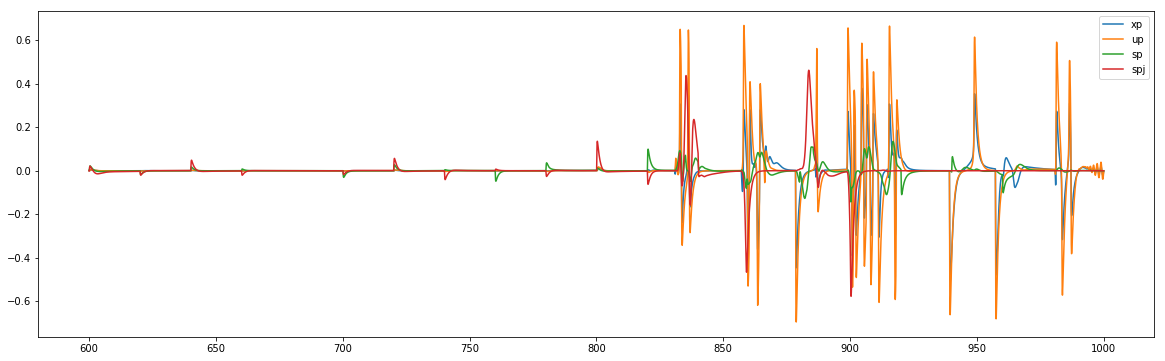

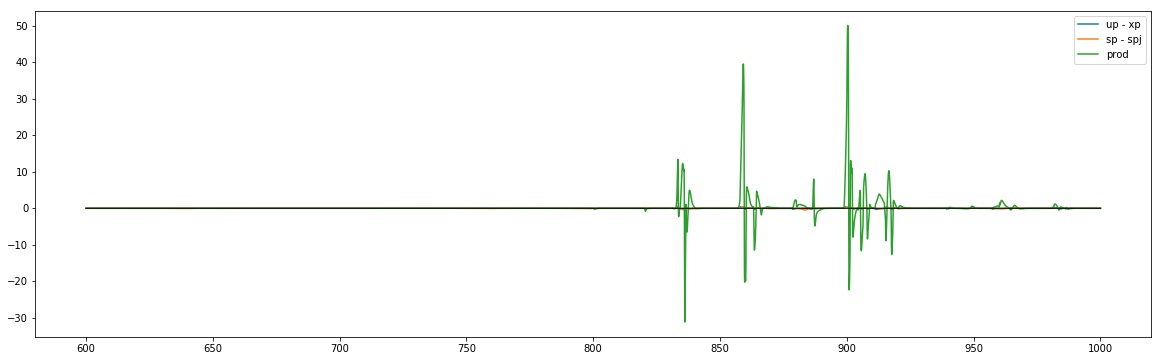

In [22]:
# plot all factors in the MX--C0 synaptic plasticity
print('X=%d' % (X))
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

AL_data:
[0.08436235 0.16322433 0.07977476 0.06984957 0.07017214 0.0924045 ]


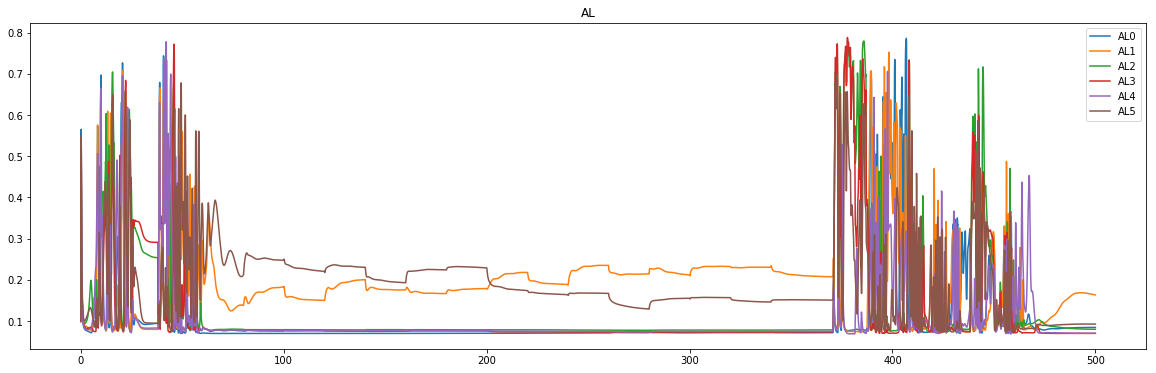

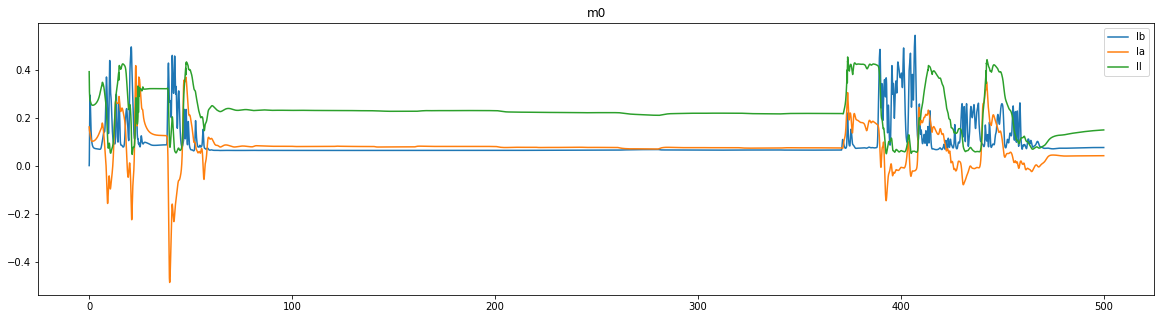

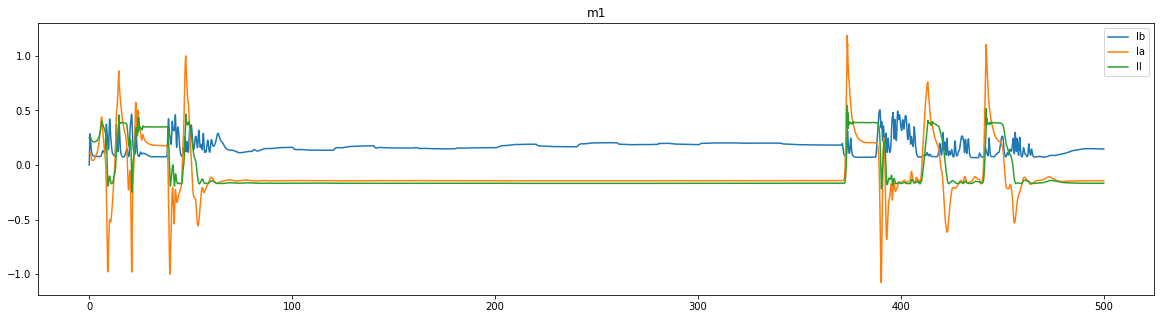

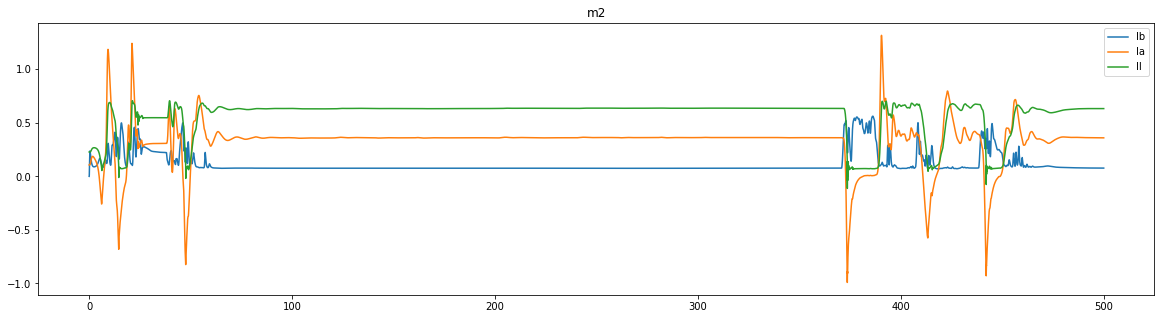

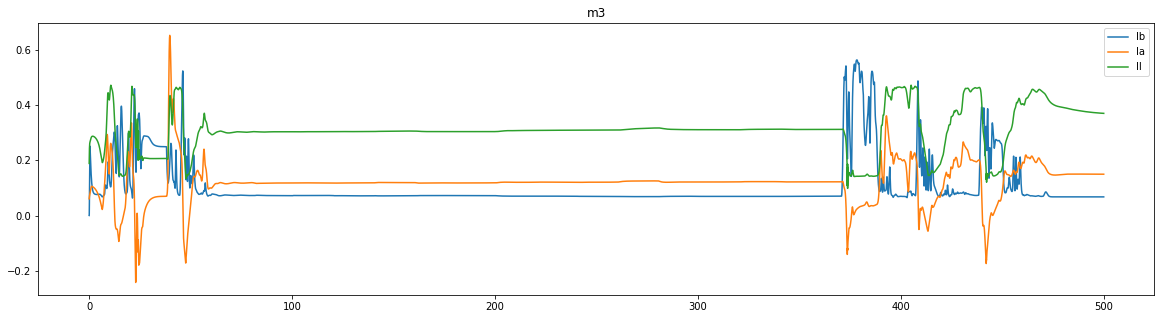

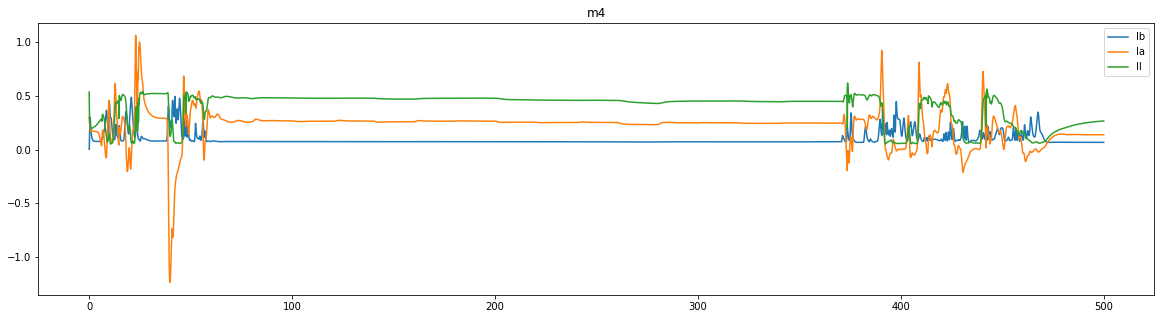

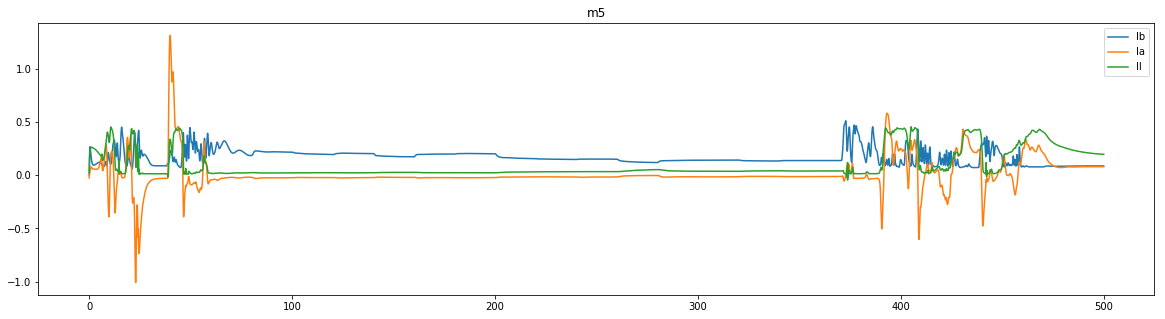

In [9]:
# Alpha units
AL_fig = plt.figure(figsize=fs)
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose())
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
fs = (20,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times, Ib, times, Ia, times, II)
    #plt.plot(times, Ib)
    plt.legend(legs)
    plt.title('m' + str(i))
plt.show()

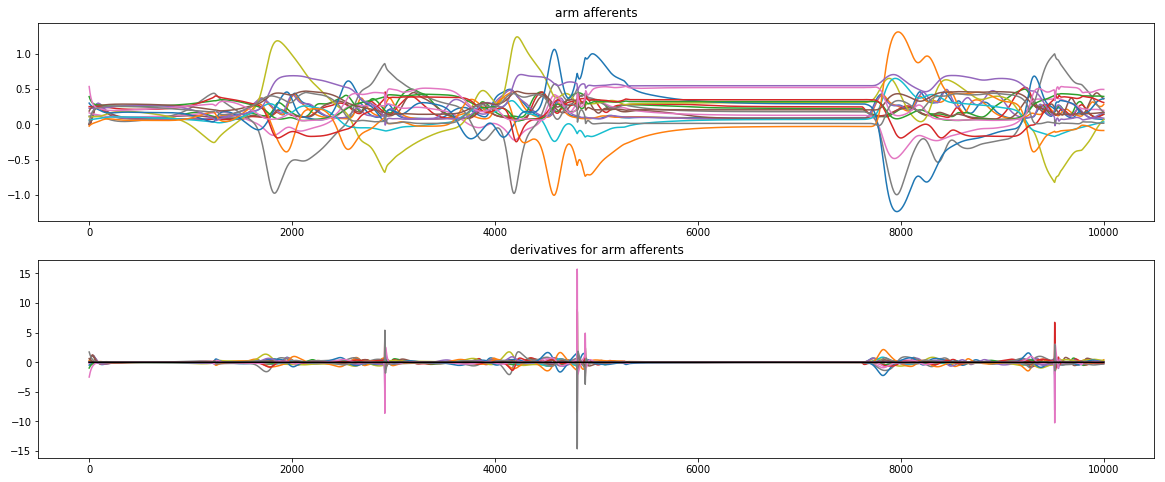

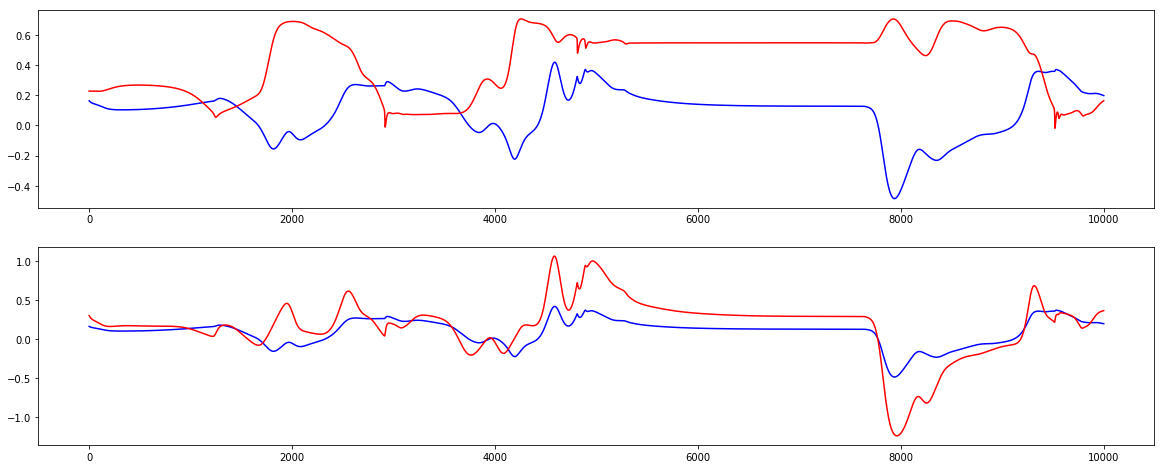

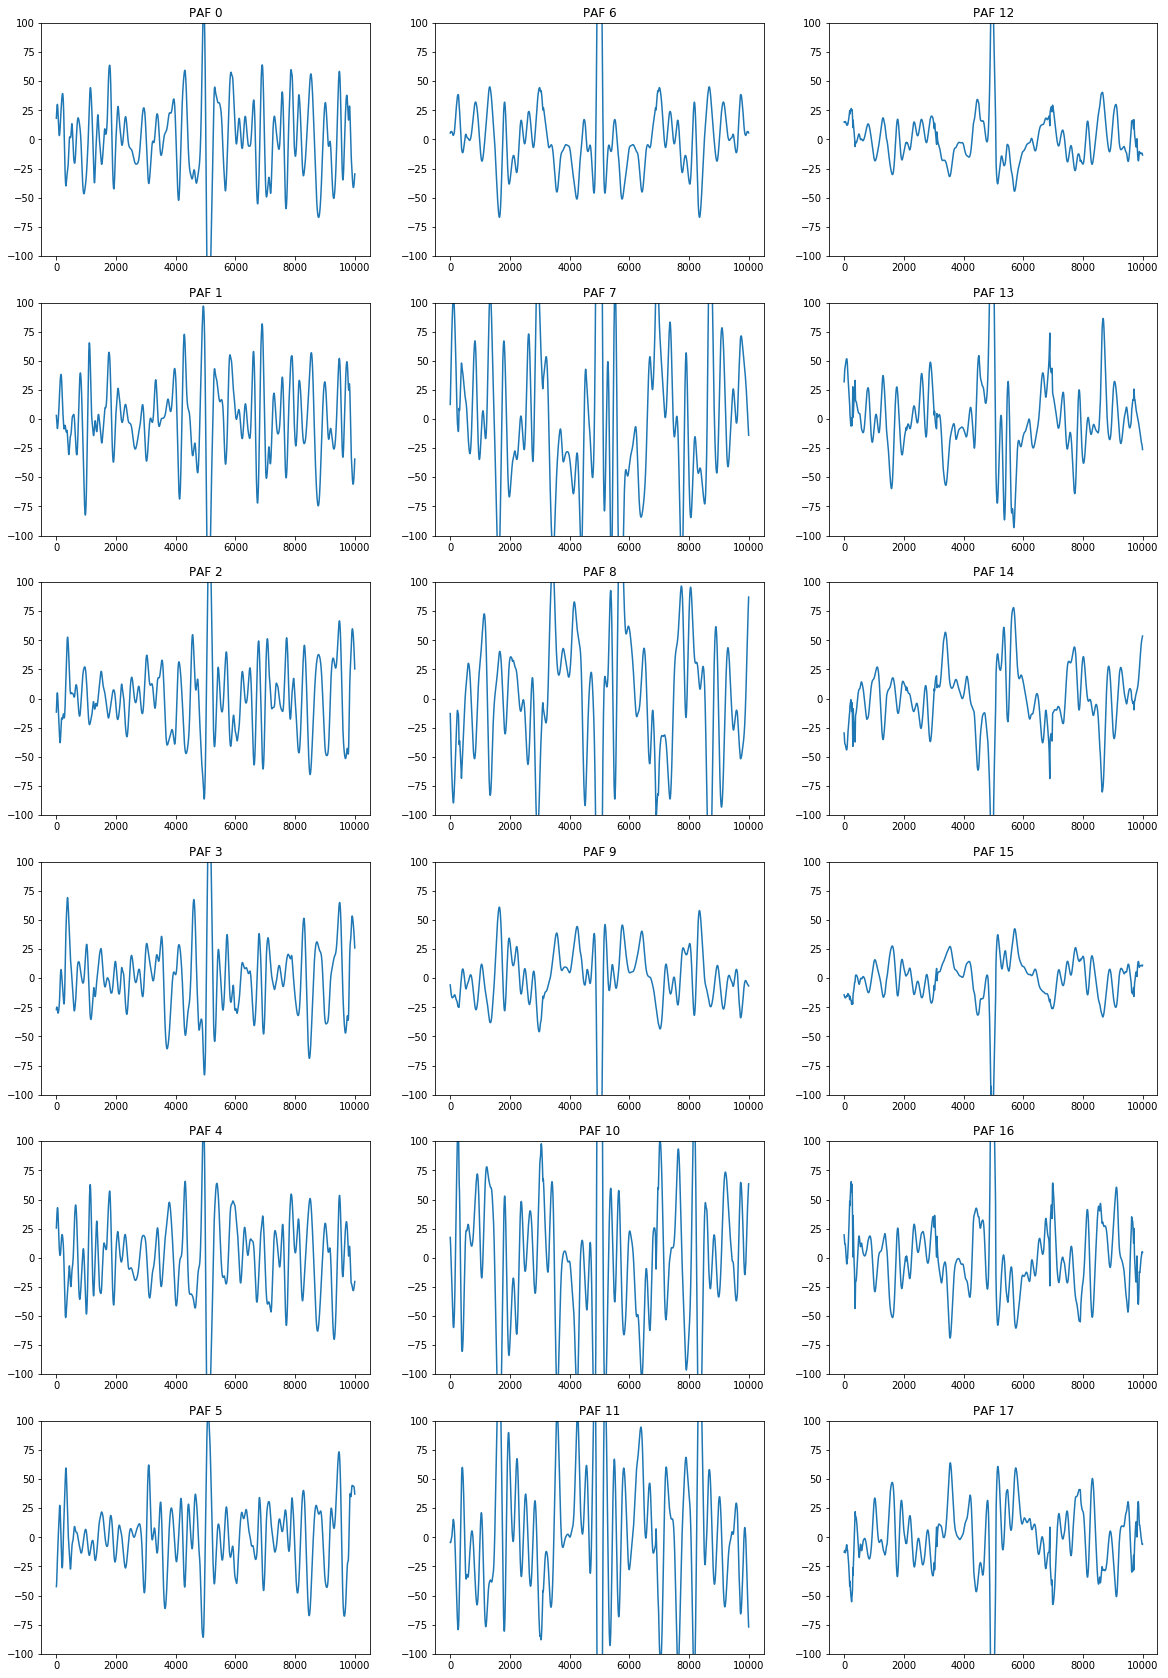

In [10]:
# ANALYSIS OF CORRELATIONS BETWEEN ARM AFFERENTS

# obtaining arm afferents and their derivatives
PAF = arm_activs[:10000, 22:40]
PAF_diff = np.gradient(PAF, axis=0) / net.min_delay
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(PAF)
axs[0].set_title('arm afferents')
axs[1].plot(PAF_diff)
axs[1].set_title('derivatives for arm afferents')
axs[1].plot(np.zeros(PAF_diff.shape[0]), 'k')

# comparing some signals
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(PAF[:,6], 'b', PAF[:,14], 'r')
axs[1].plot(PAF[:,6], 'b', PAF[:,10], 'r')

# plotting the correlation of one signal against all others
corr_fig, corr_axs = plt.subplots(6, 3, figsize=(20,30))
for col in range(3):
    for row in range(6):
        corr = np.correlate(PAF_diff[:,6], PAF_diff[:, 6*col+row], mode='same')
        corr_axs[row,col].plot(corr)
        corr_axs[row,col].set_ylim([-100,100])
        corr_axs[row,col].set_title('PAF ' + str(6*col+row))
plt.show()

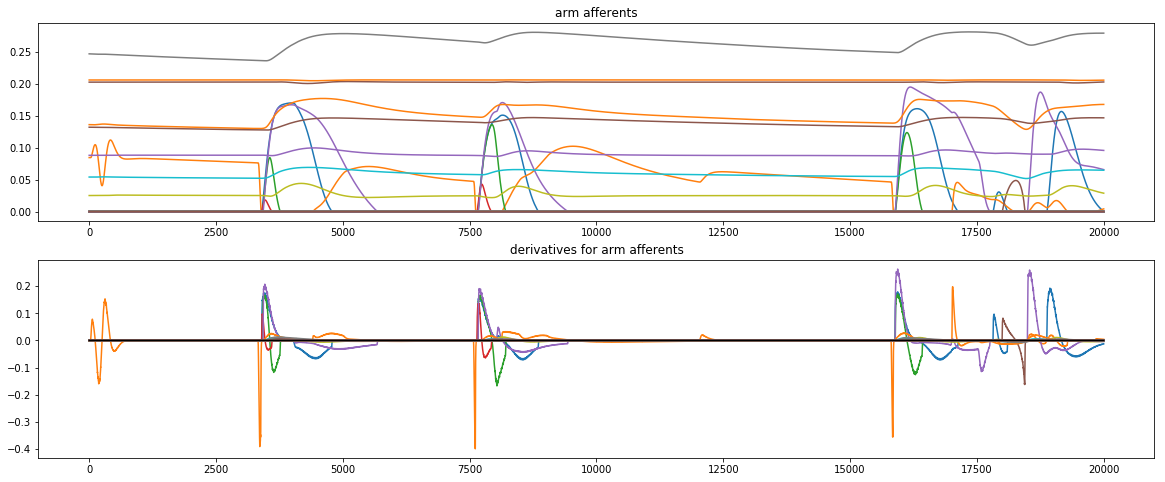

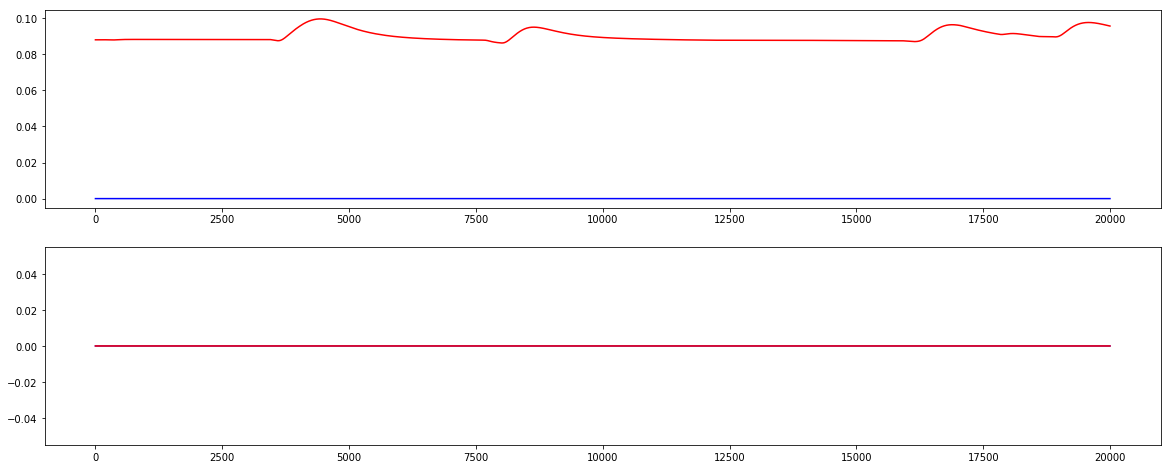

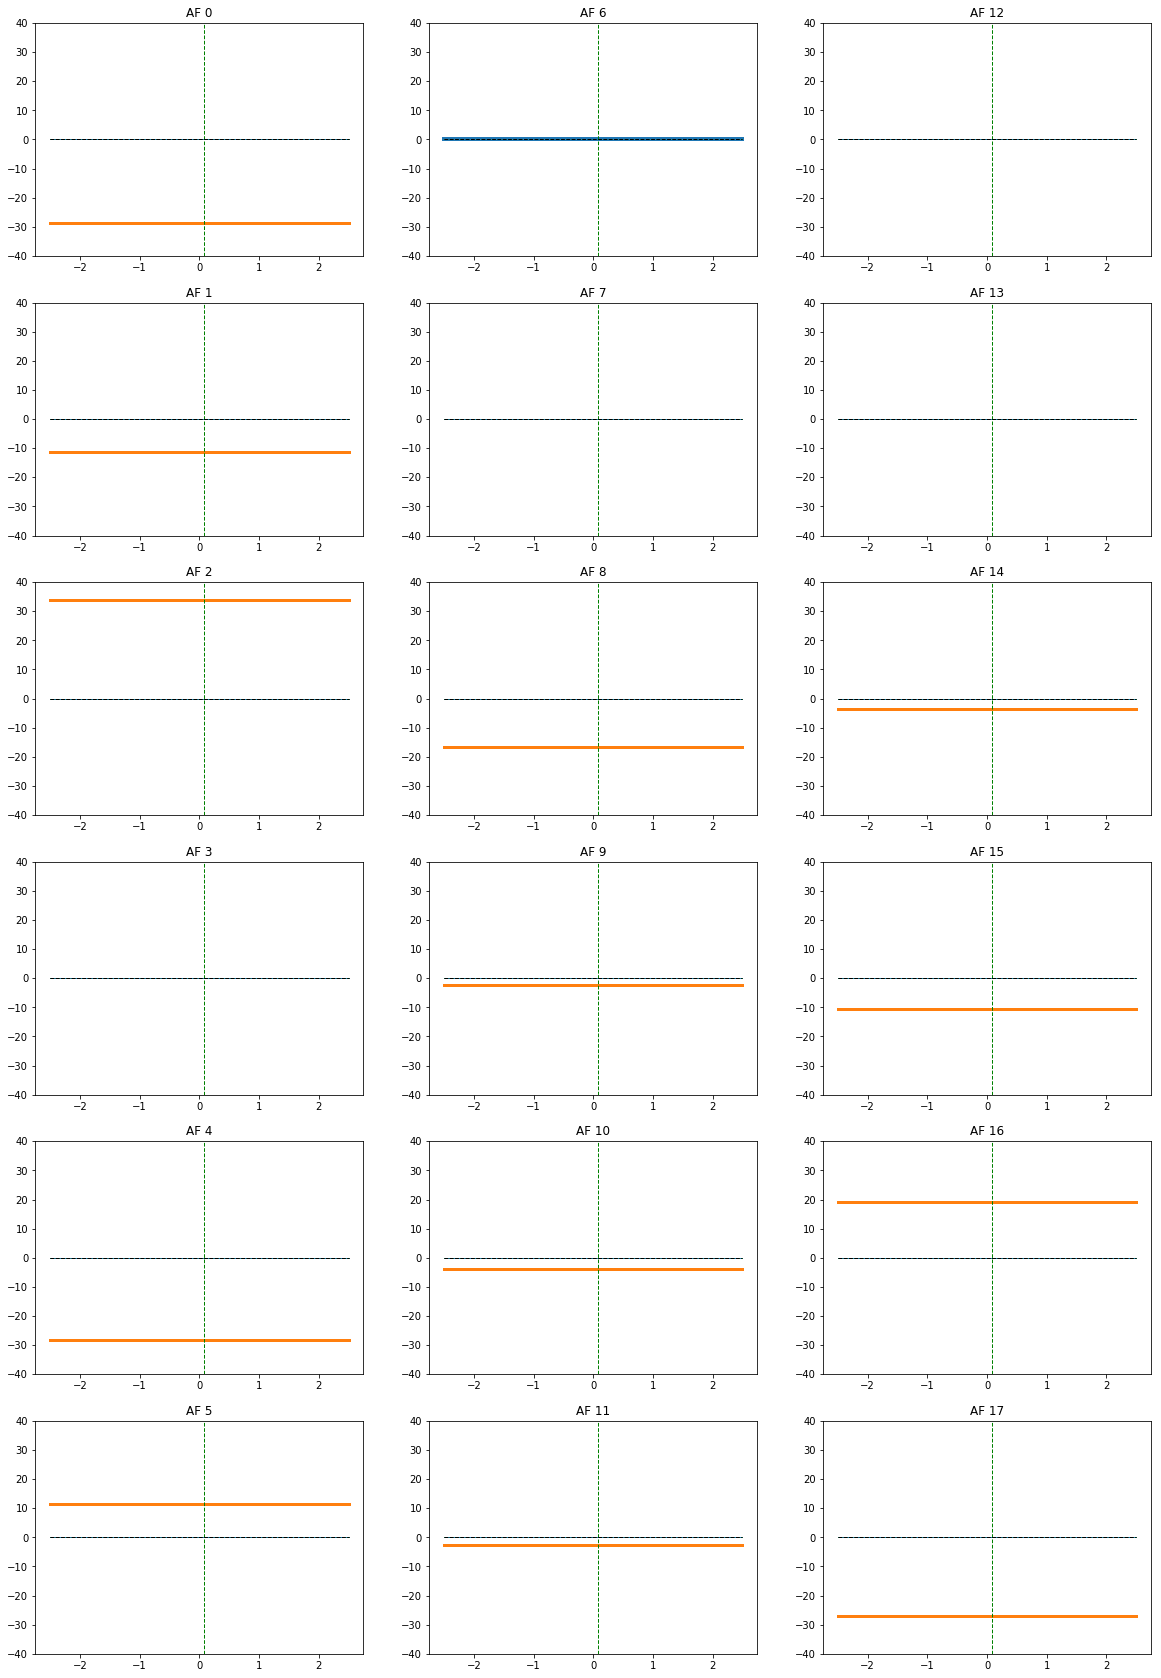

In [22]:
# ANALYSIS OF CORRELATIONS BETWEEN AFFERENT UNITS 
##############################
### NON-NORMALIZED VERSION ###
##############################
# obtaining arm afferents and their derivatives
n_points = 20000
AFD = data[AF,:n_points].transpose()
AFD_diff = np.gradient(AFD, axis=0) / net.min_delay
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(AFD)
axs[0].set_title('arm afferents')
axs[1].plot(AFD_diff)
axs[1].set_title('derivatives for arm afferents')
axs[1].plot(np.zeros(AFD_diff.shape[0]), 'k')

# comparing some signals
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(AFD[:,6], 'b', AFD[:,14], 'r')
axs[1].plot(AFD_diff[:,6], 'b', AFD[:,10], 'r')

# plotting the correlation of one signal against all others
AF__M0_w = [syn.w for syn in net.syns[M[0]] if syn.preID in AF]
corr_fig, corr_axs = plt.subplots(6, 3, figsize=(20,30))
base_idx = 6 # index for positive Ia afferent for muscle 0
mid = int(round(AFD.shape[0]/2.)) # middle index for the signal (where 0 is)
span = min(500, mid)   # span to plot for the correlation
t = np.linspace(-span*net.min_delay, span*net.min_delay, 2*span)
max_c = 40
min_c = -40
des_val_idx = mid + AF__M_syn['extra_steps']
for col in range(3):
    for row in range(6):
        cur_idx = 6*col+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        corr = np.correlate(AFD_diff[:,base_idx], AFD[:,cur_idx], mode='same') # what M0 should be obtaining?
        corr_axs[row,col].plot(t, corr[mid-span:mid+span], linewidth=lw)
        corr_axs[row,col].set_ylim([min_c,max_c])
        corr_axs[row,col].plot(t, 20.*AF__M0_w[cur_idx]*np.ones(len(t)), linewidth=3)
        corr_axs[row,col].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        x = t[int(len(t)/2)+AF__M_syn['extra_steps']]
        corr_axs[row,col].plot([x, x], [min_c, max_c], 'g--', linewidth=1)
        corr_axs[row,col].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        corr_axs[row,col].set_title('AF ' + str(cur_idx))
plt.show()

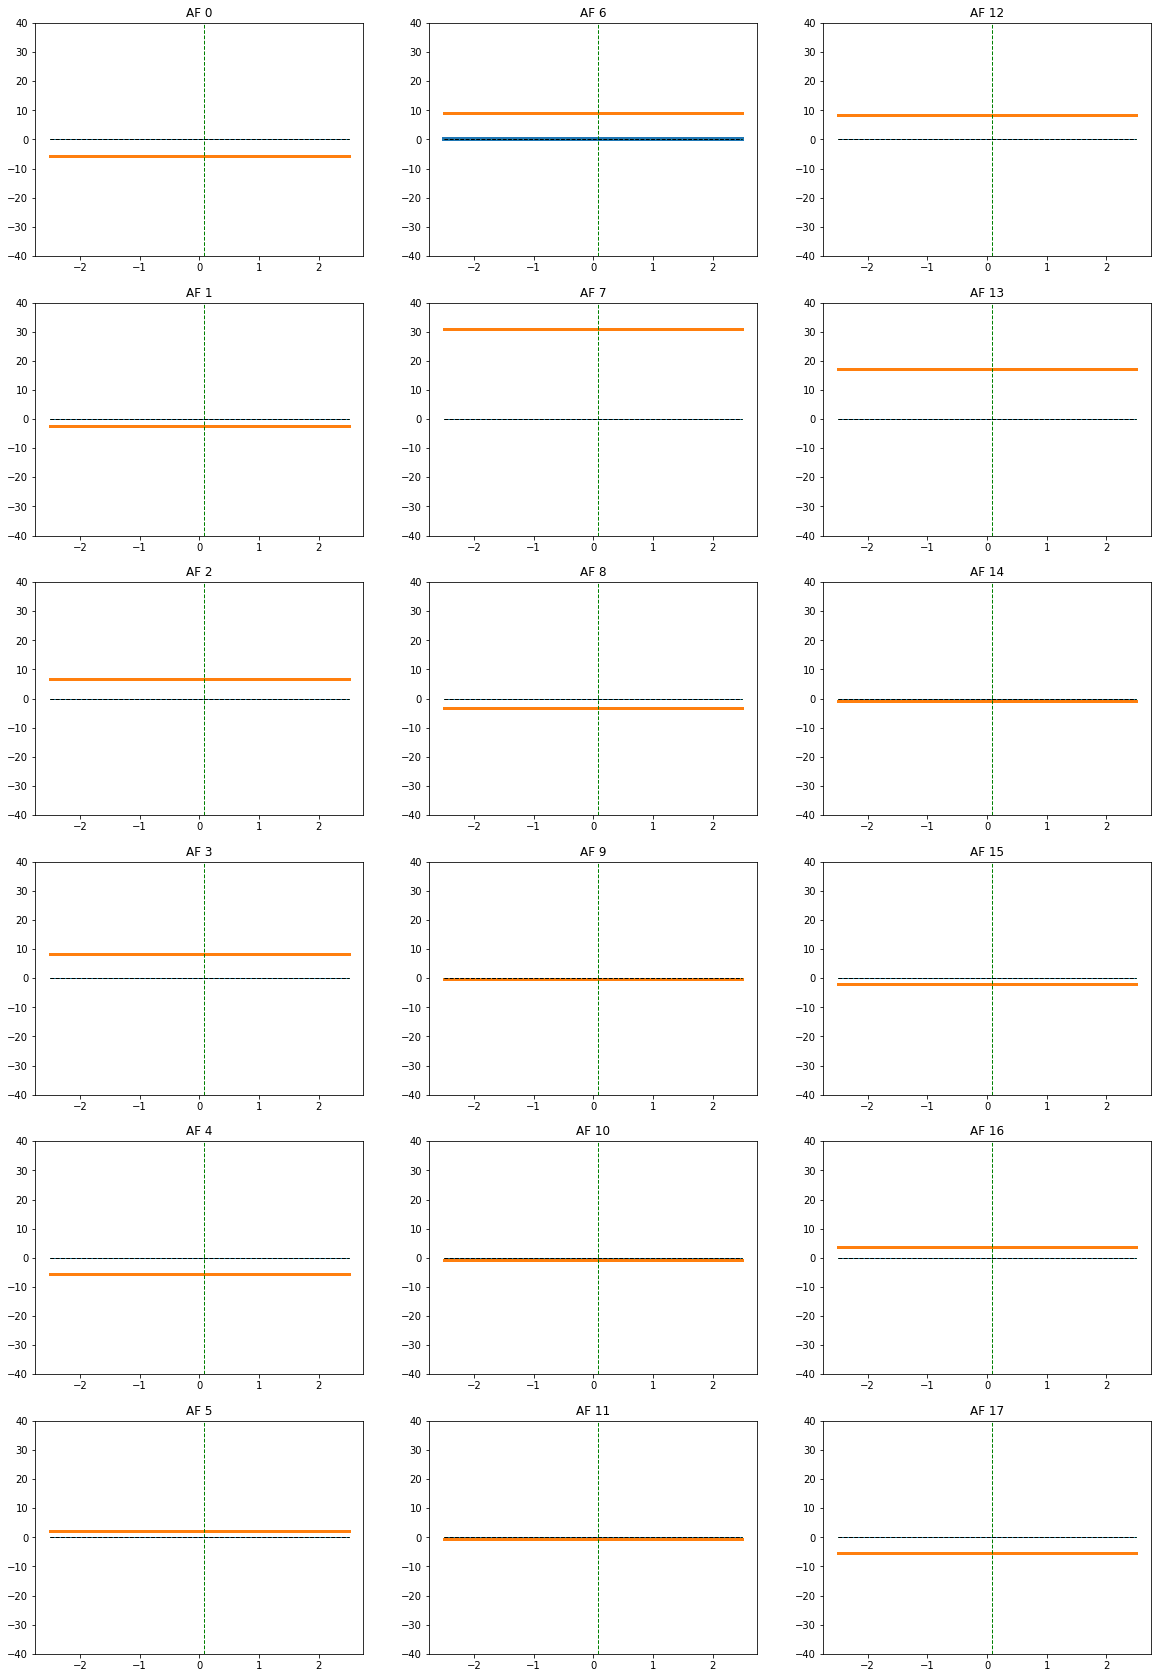

In [23]:
# plotting AF_diff VS AF_diff instead of AF_diff VS AF, to see if 
# the correlations are more informative
corr_fig2, corr_axs2 = plt.subplots(6, 3, figsize=(20,30))
for col in range(3):
    for row in range(6):
        cur_idx = 6*col+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        corr = np.correlate(AFD_diff[:,base_idx], AFD_diff[:,cur_idx], mode='same')
        corr_axs2[row,col].plot(t, corr[mid-span:mid+span], linewidth=lw)
        corr_axs2[row,col].set_ylim([min_c,max_c])
        corr_axs2[row,col].plot(t, 4.*AF__M0_w[cur_idx]*np.ones(len(t)), linewidth=3)
        corr_axs2[row,col].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        x = t[int(len(t)/2)+AF__M_syn['extra_steps']]
        corr_axs2[row,col].plot([x, x], [min_c, max_c], 'g--', linewidth=1)
        corr_axs2[row,col].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        corr_axs2[row,col].set_title('AF ' + str(cur_idx))
plt.show()

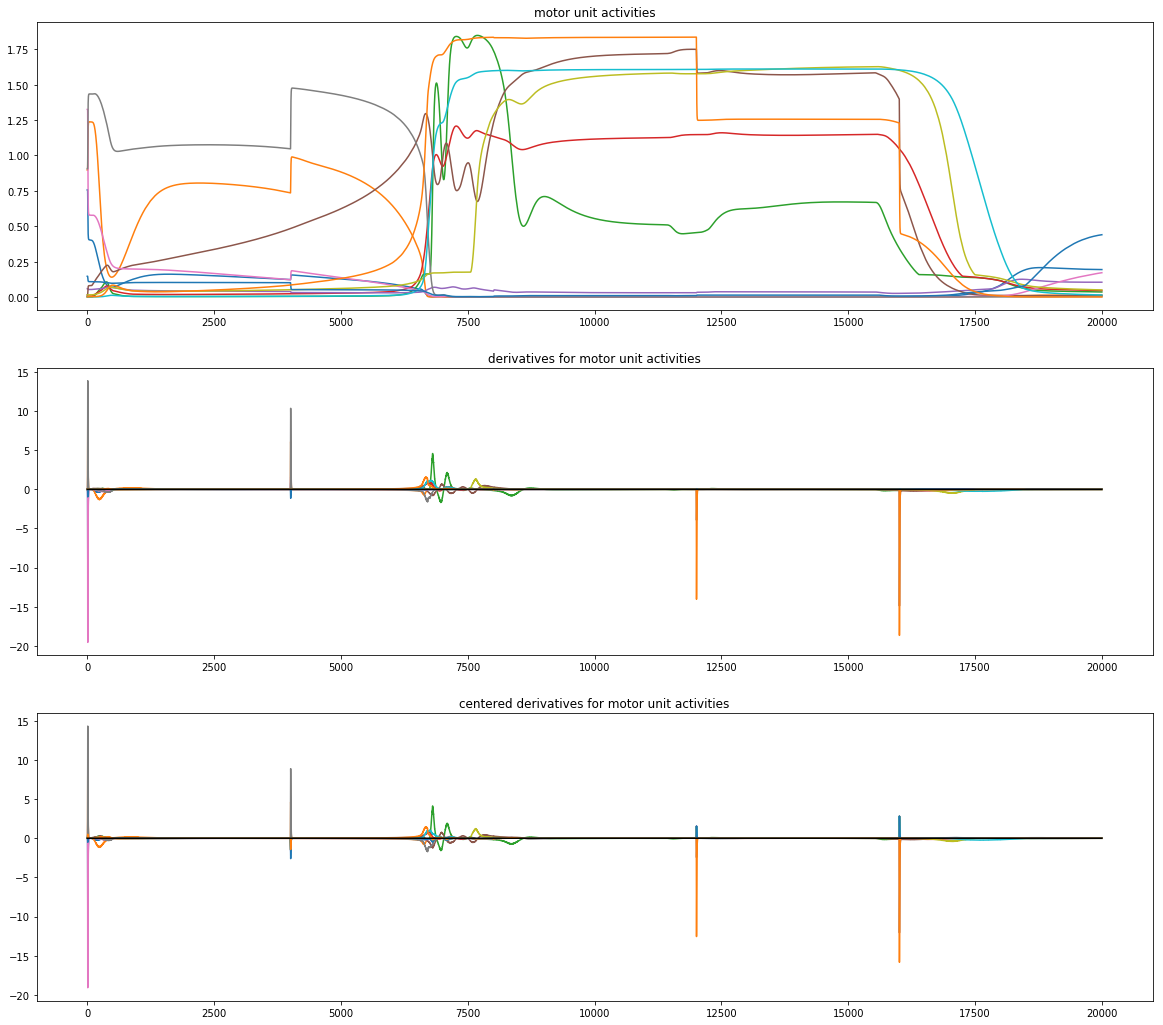

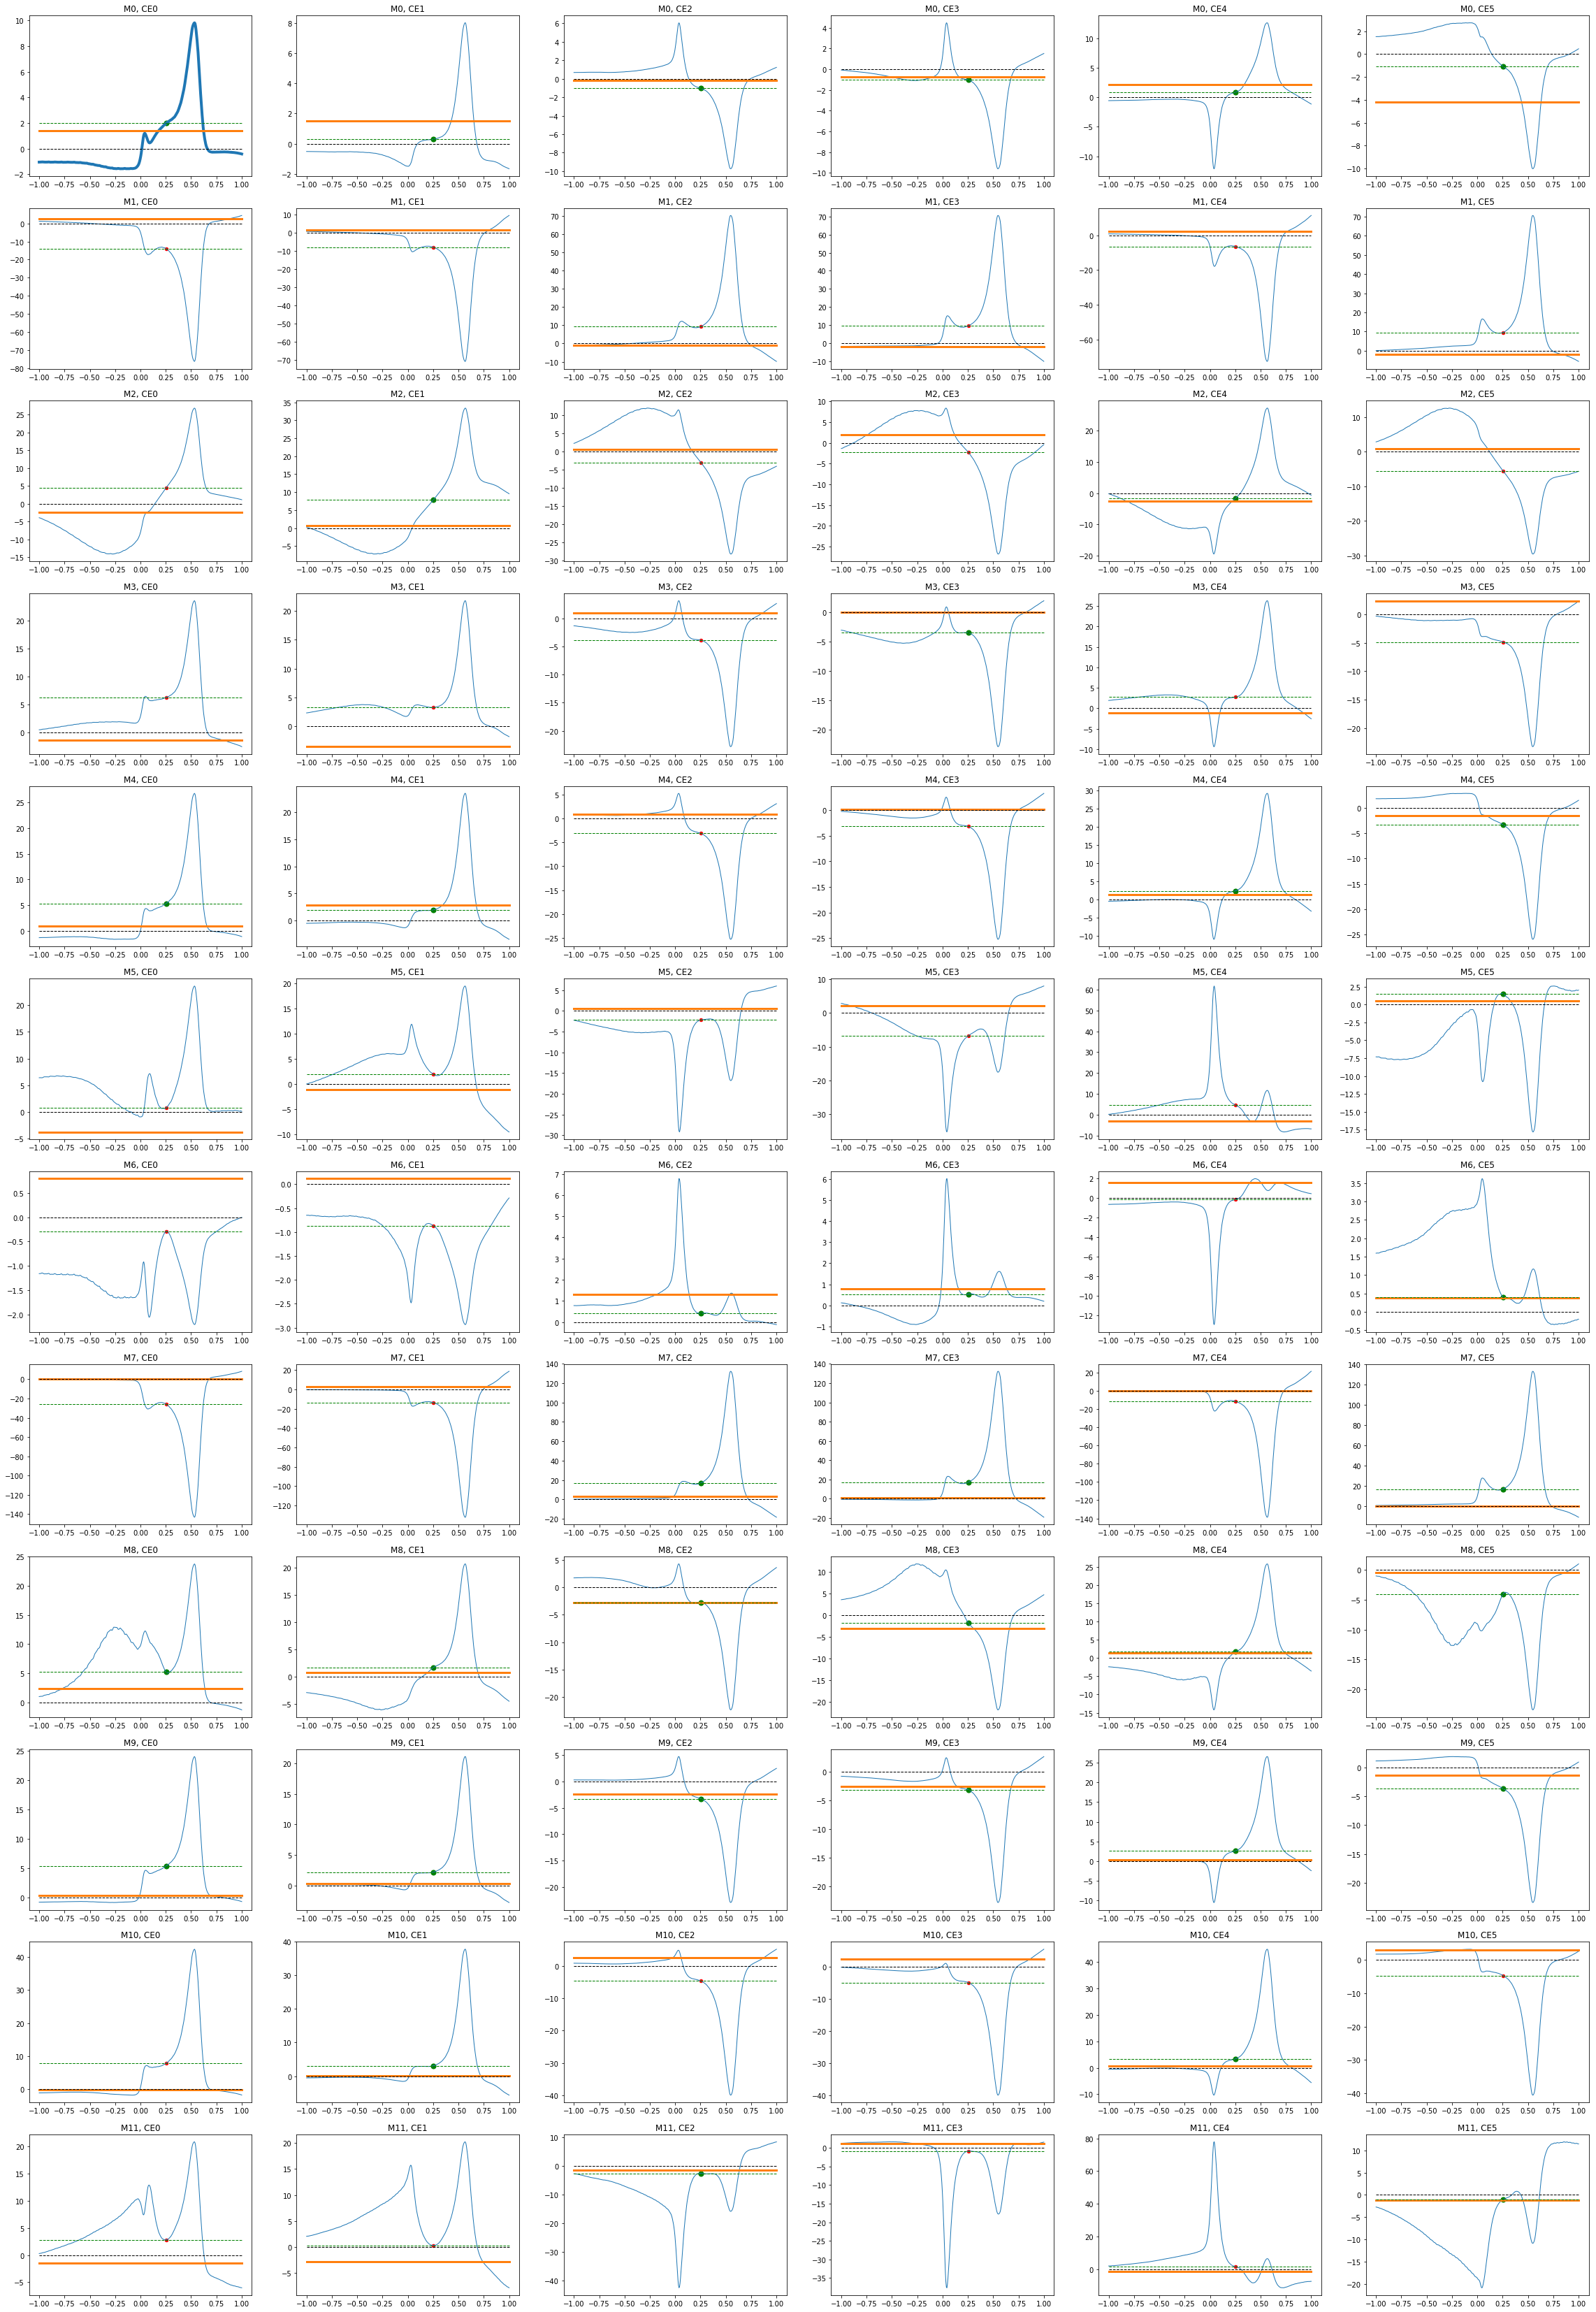

[[1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1.]
 [0. 0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1.]]
[4. 6. 6. 6. 6. 8.]
[6. 0. 2. 1. 4. 1. 3. 3. 6. 6. 2. 2.]
0.5
normalized M__CE correlation weight matrix:
[[ 0.06028626, 0.01546077, -0.04839481, -0.04563335, 0.05556171, -0.04767689]
, [-0.42367317, -0.42765179, 0.43431508, 0.43267686, -0.42234843, 0.42137164]
, [ 0.13629201, 0.42074445, -0.13697257, -0.10066377, -0.10481919, -0.24742266]
, [ 0.19137488, 0.17211476, -0.18052259, -0.15696369, 0.17797525, -0.21706773]
, [ 0.16144798, 0.10625066, -0.14575678, -0.14228993, 0.15232289, -0.14871797]
, [ 0.02518296, 0.1042084, -0.10285915, -0.30385411, 0.30666528, 0.06586649]
, [-0.00881661, -0.04651115, 0.01892494, 0.02398486, -0.01167367, 0.01775606]
, [-0.78694812, -0.73241913, 0.78837214, 0.76695571, -0.74853559, 0.76048719]
, [ 0.15891418

In [14]:
# ANALYSIS OF CORRELATIONS BETWEEN MOTOR UNITS, CE

# obtaining M,C unit activities and their derivatives
full_size = len(data[M[0]])
M_size = 20000 # number of points we will take from the M data signals
C_span = 8000 # number of points in half of the C data moving window
center_idx = int(round(full_size/2))
MD = data[M, -M_size:].transpose()
MD_diff = np.gradient(MD, axis=0) / net.min_delay
MD_diff_means = np.tile(np.mean(MD_diff, axis=1), (12,1)).transpose()
MD_diff_center = MD_diff - MD_diff_means
CED = data[CE, center_idx-C_span:center_idx+C_span].transpose()
CED_diff = np.gradient(CED, axis=0) / net.min_delay
CED_diff_means = np.tile(np.mean(CED_diff, axis=1), (6,1)).transpose()
CED_diff_center = CED_diff - CED_diff_means
fig, axs = plt.subplots(3, 1, figsize=(20, 18))
axs[0].plot(MD)
axs[0].set_title('motor unit activities')
axs[1].plot(MD_diff)
axs[1].set_title('derivatives for motor unit activities')
axs[1].plot(np.zeros(MD_diff.shape[0]), 'k')
axs[2].plot(MD_diff_center)
axs[2].set_title('centered derivatives for motor unit activities')
axs[2].plot(np.zeros(MD_diff_center.shape[0]), 'k')

# plotting the correlation of one signal against all others
M__CE_w = [[syn.w for syn in net.syns[c] if syn.preID in M] for c in CE]
corr_fig, corr_axs = plt.subplots(12, 6, figsize=(40,60))
base_idx = 0 # index for positive Ia afferent for muscle 0
mid = int(round((M_size - 2*C_span)/2)) # index of the middle 0 shift value
plt_span = min(200, mid)   # span to plot for the correlation
t = np.linspace(-plt_span*net.min_delay, plt_span*net.min_delay, 2*plt_span)
max_c = 90
min_c = -90
eqs = np.zeros((12,6)) # matrix indicating whether weight and correlation have same sign
corr_w = np.zeros((12,6)) # what the weight should be, according to the correlation
#des_val_idx = mid + 12
des_val_idx = mid + CE_params['custom_inp_del']
for col in range(6):
    for row in range(12):
        cur_idx = 12*col+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        corr = np.correlate(CED_diff_center[:,col], -MD_diff_center[:,row], mode='valid')
        corr_axs[row,col].plot(t, corr[mid-plt_span:mid+plt_span], linewidth=lw)
        #corr_axs[row,col].set_ylim([min_c,max_c])
        corr_w[row,col] = corr[des_val_idx]
        corr_axs[row,col].plot(t, 5.*M__CE_w[col][row]*np.ones(len(t)), linewidth=3)
        corr_axs[row,col].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        x = t[int(len(t)/2) +CE_params['custom_inp_del']]
        #x = t[int(len(t)/2) + 12]
        #corr_axs[row,col].plot([x, x], [min_c, max_c], 'g--', linewidth=1)
        corr_axs[row,col].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        corr_axs[row,col].set_title('M' + str(row) + ', CE' + str(col))
        # Finding if weights are following the correlations
        scat_s = 20
        scat_c = 'r'
        if np.sign(M__CE_w[col][row]) == np.sign(corr[des_val_idx]):
            eqs[row,col] = 1.
            scat_s = 50
            scat_c = 'g'
        corr_axs[row,col].scatter([x], [corr[des_val_idx]], s=scat_s, c=scat_c)
plt.show()

# Regarding whether correlations and weights have the same sign
print(eqs)
print(np.sum(eqs, axis=0))
print(np.sum(eqs, axis=1))
print(sum(eqs.flatten())/(12*6))
# Regarding desired weights according to correlations
# normalizing columns of corr_w (weights on the same C unit)
n_corr_w = corr_w / np.linalg.norm(corr_w, axis=0)
print('normalized M__CE correlation weight matrix:')
import re
print(re.sub('\[,', '[', re.sub('\ +', ', ', str(n_corr_w))))

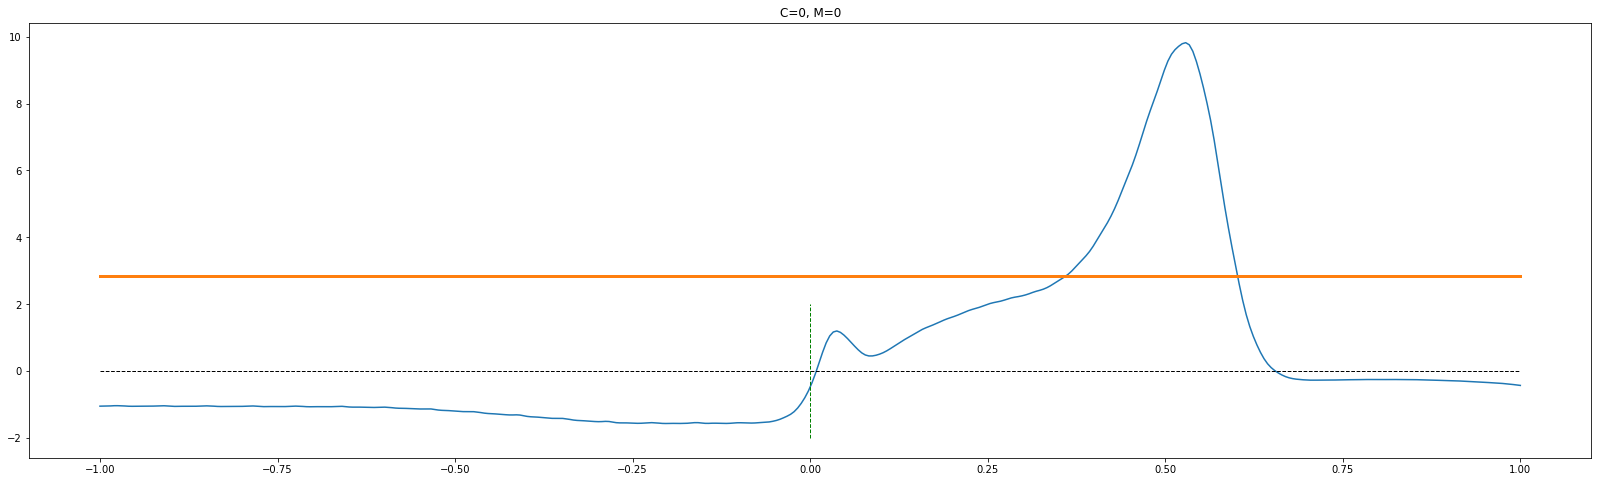

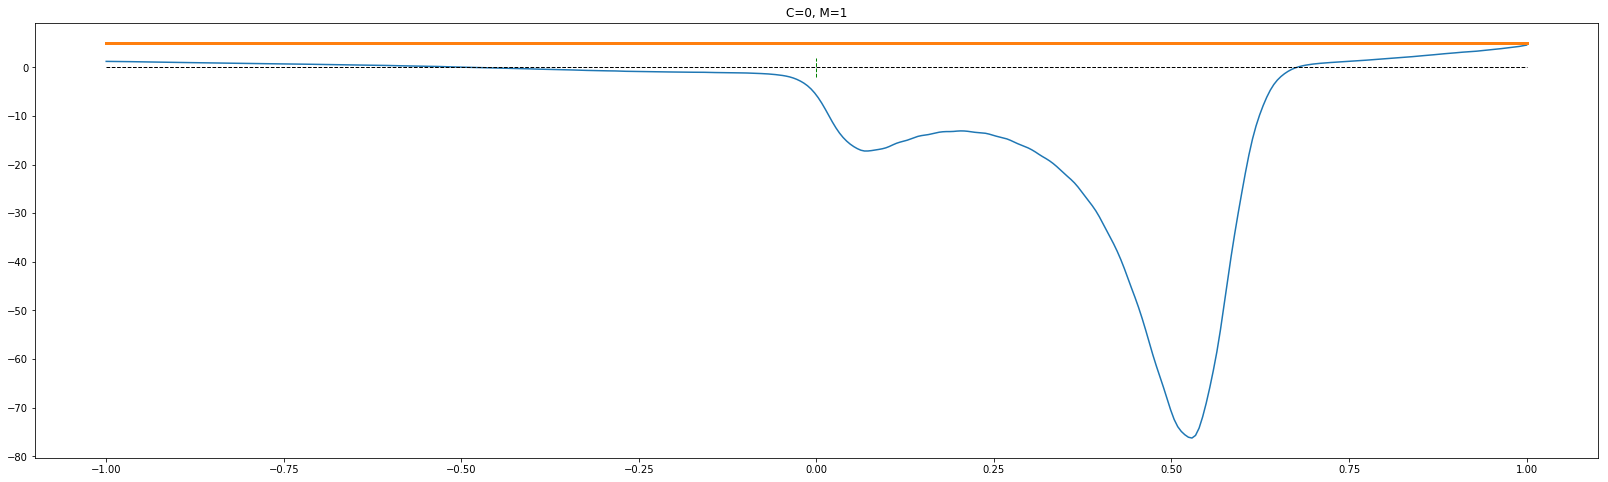

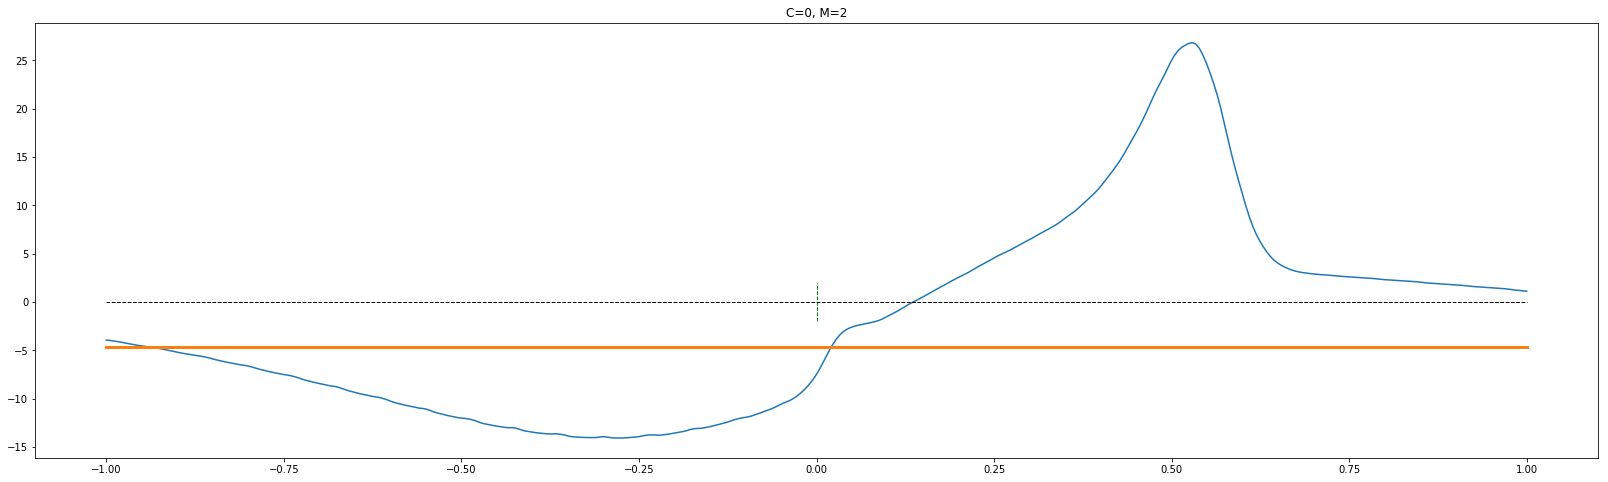

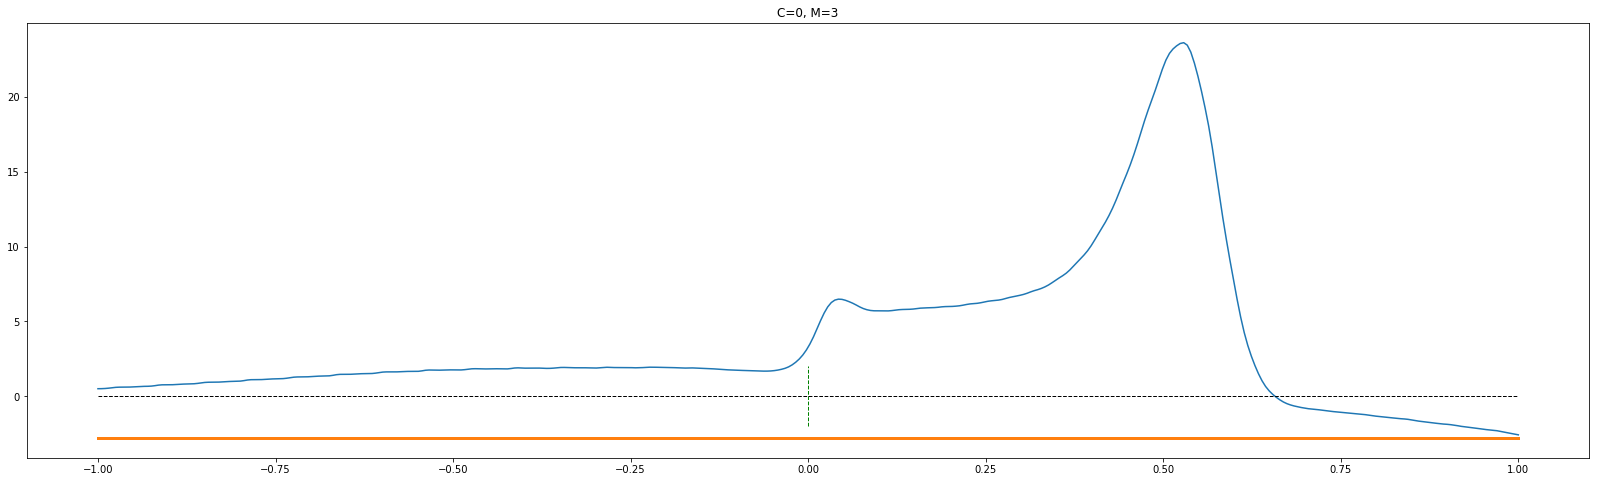

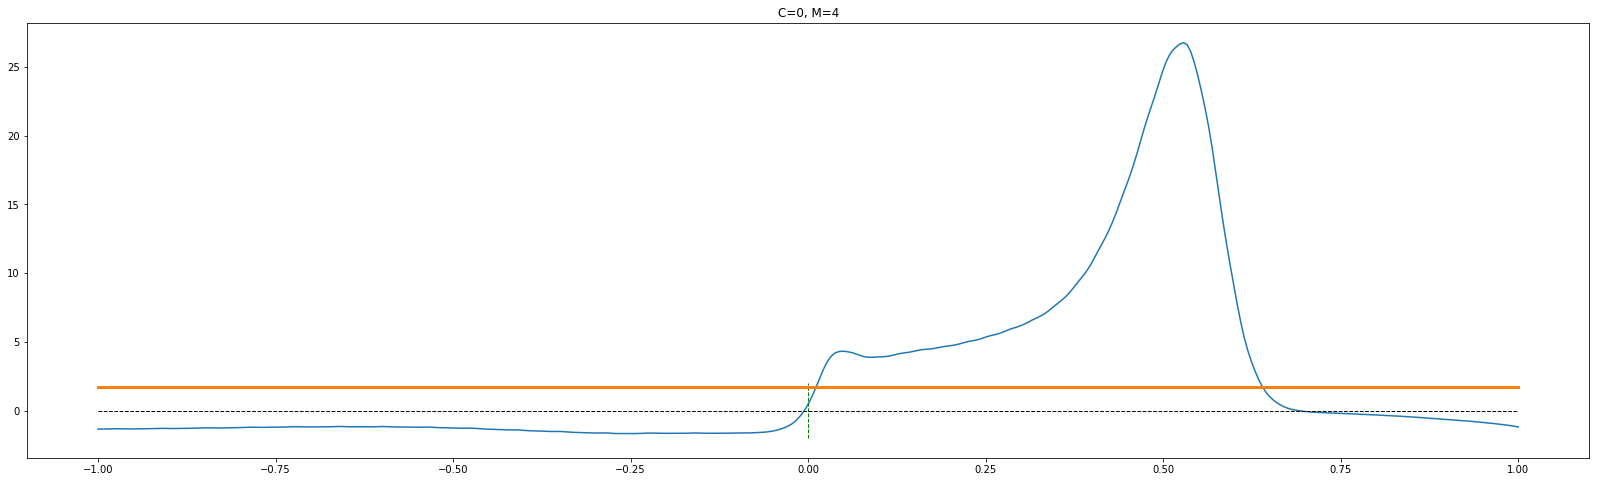

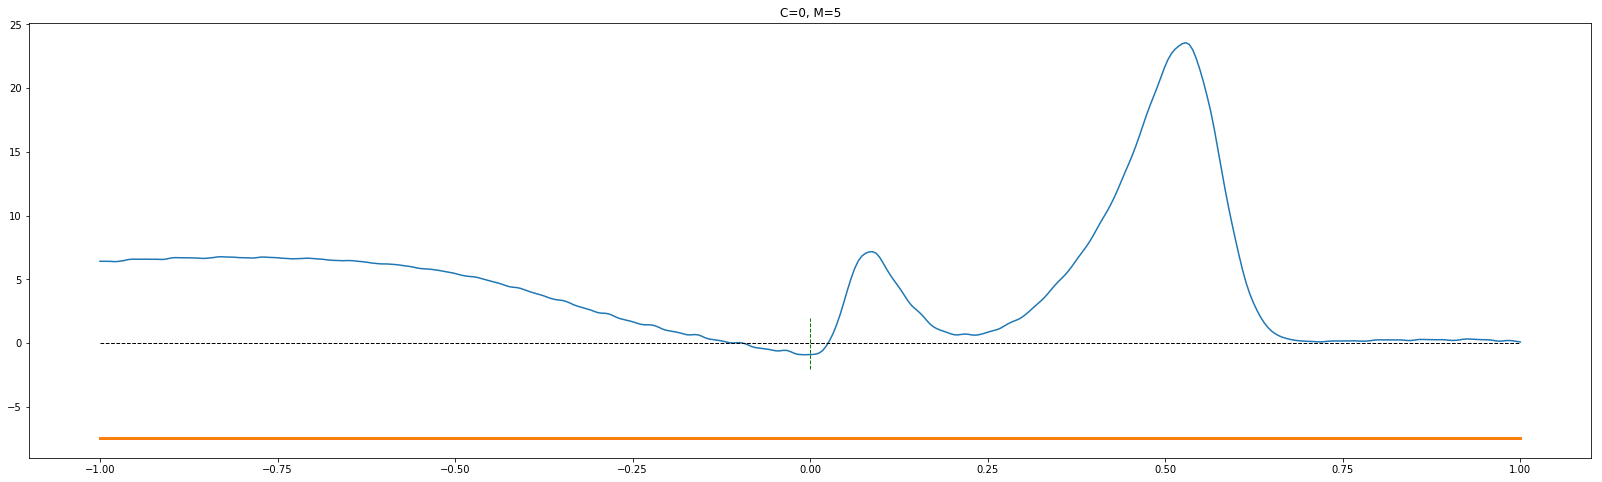

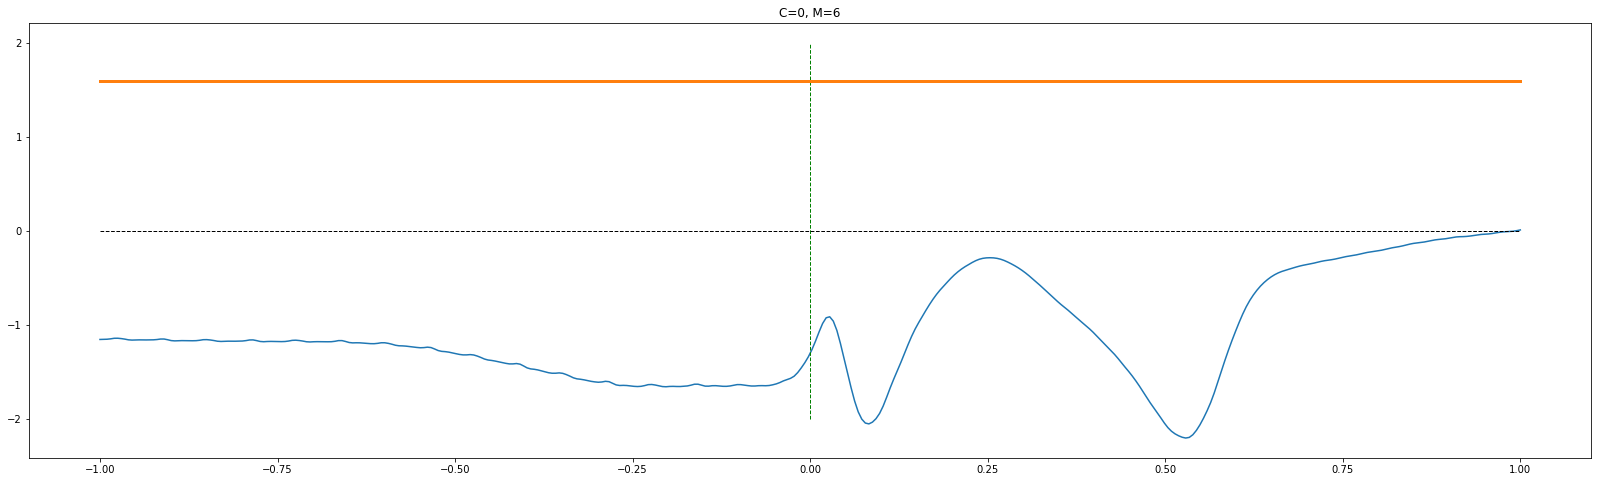

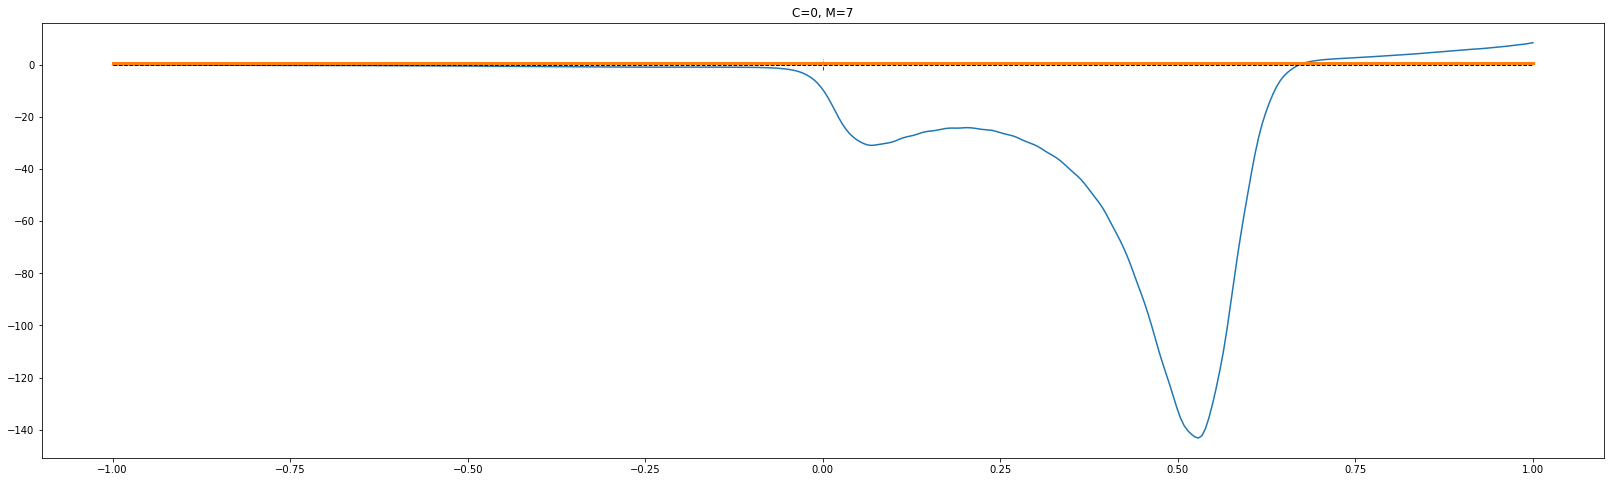

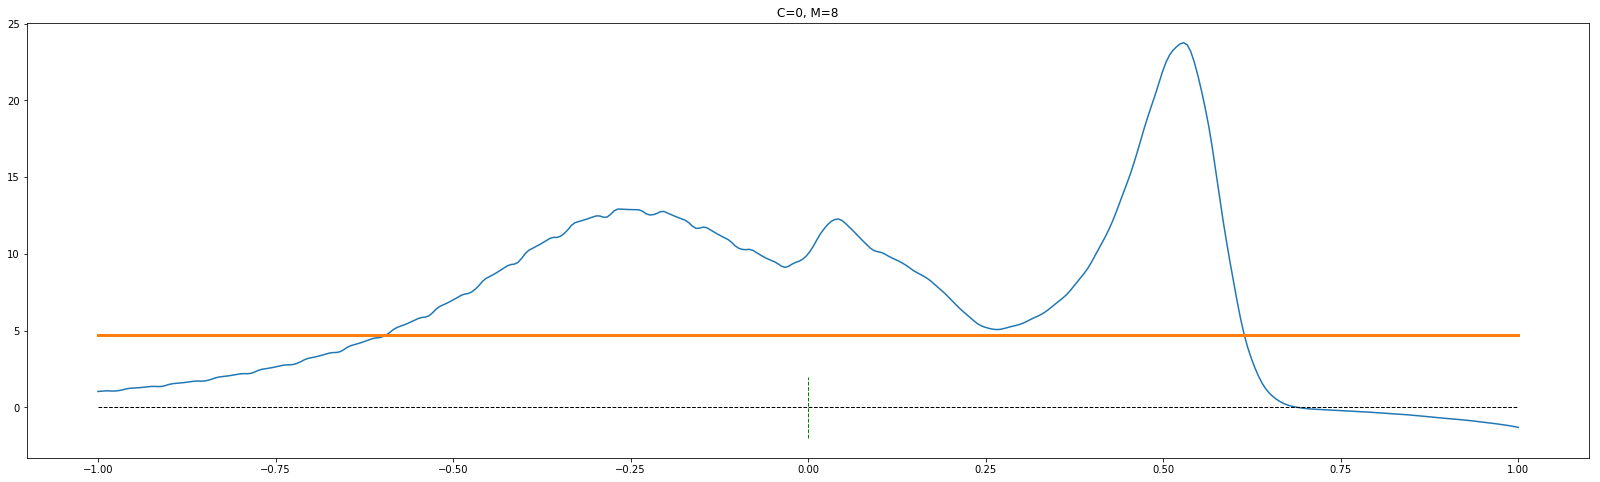

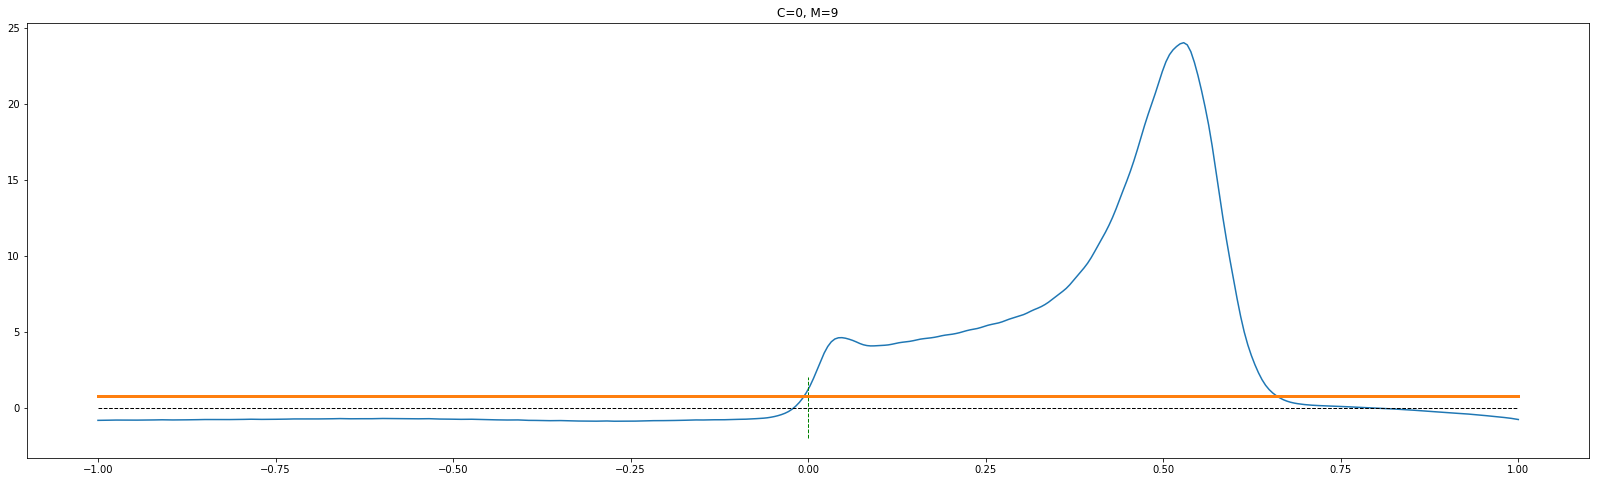

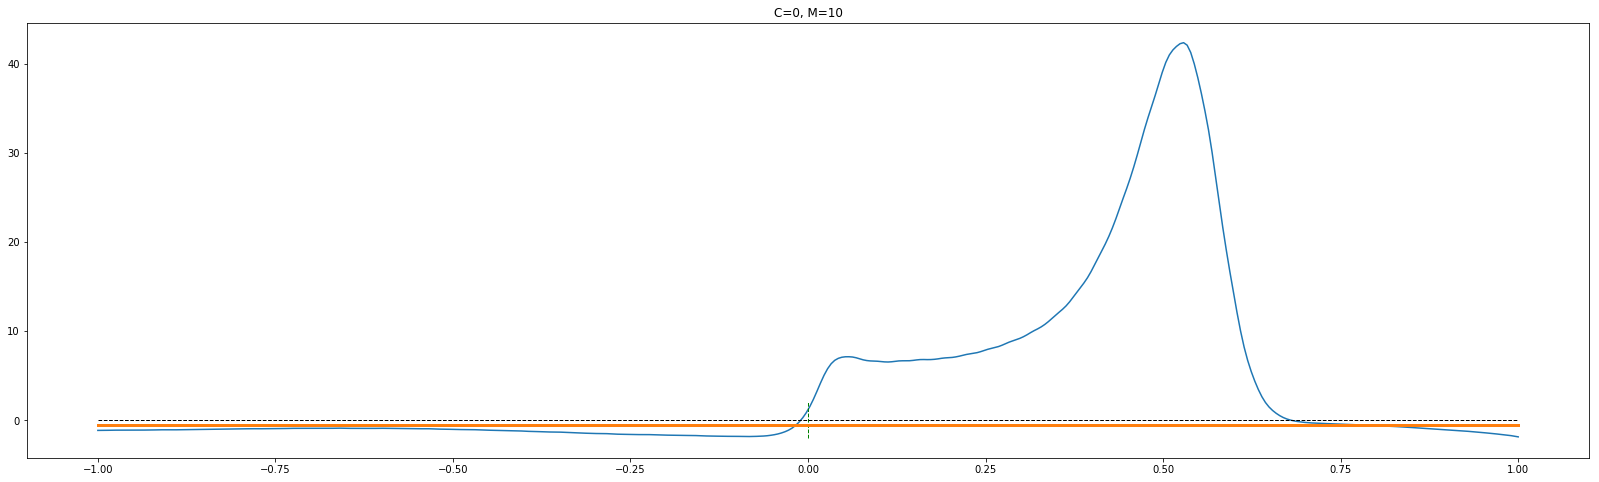

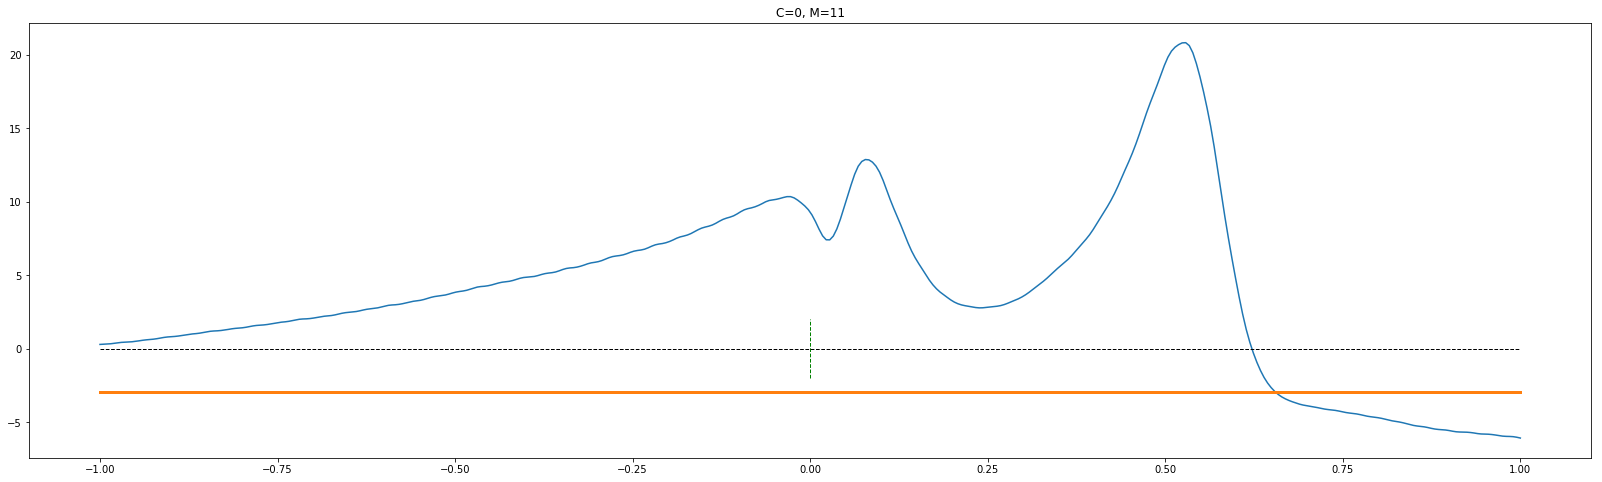

In [15]:
# CLOSEUP OF SOME CORRELATIONS
span = 200
c = 0
for m in range(12):
    corr = np.correlate(CED_diff_center[:,c], -MD_diff_center[:,m], mode='same')
    fig = plt.figure(figsize=(28,8))
    x = int(len(corr)/2)
    plt.plot(t, corr[x-span:x+span])
    plt.plot([0, 0], [-2., 2], 'g--', linewidth=1)
    plt.plot(t, np.zeros(2*span), 'k--', linewidth=1)
    plt.plot(t, 10.*M__CE_w[c][m]*np.ones(2*span), linewidth=3)
    plt.title('C=%d, M=%d' % (c,m))

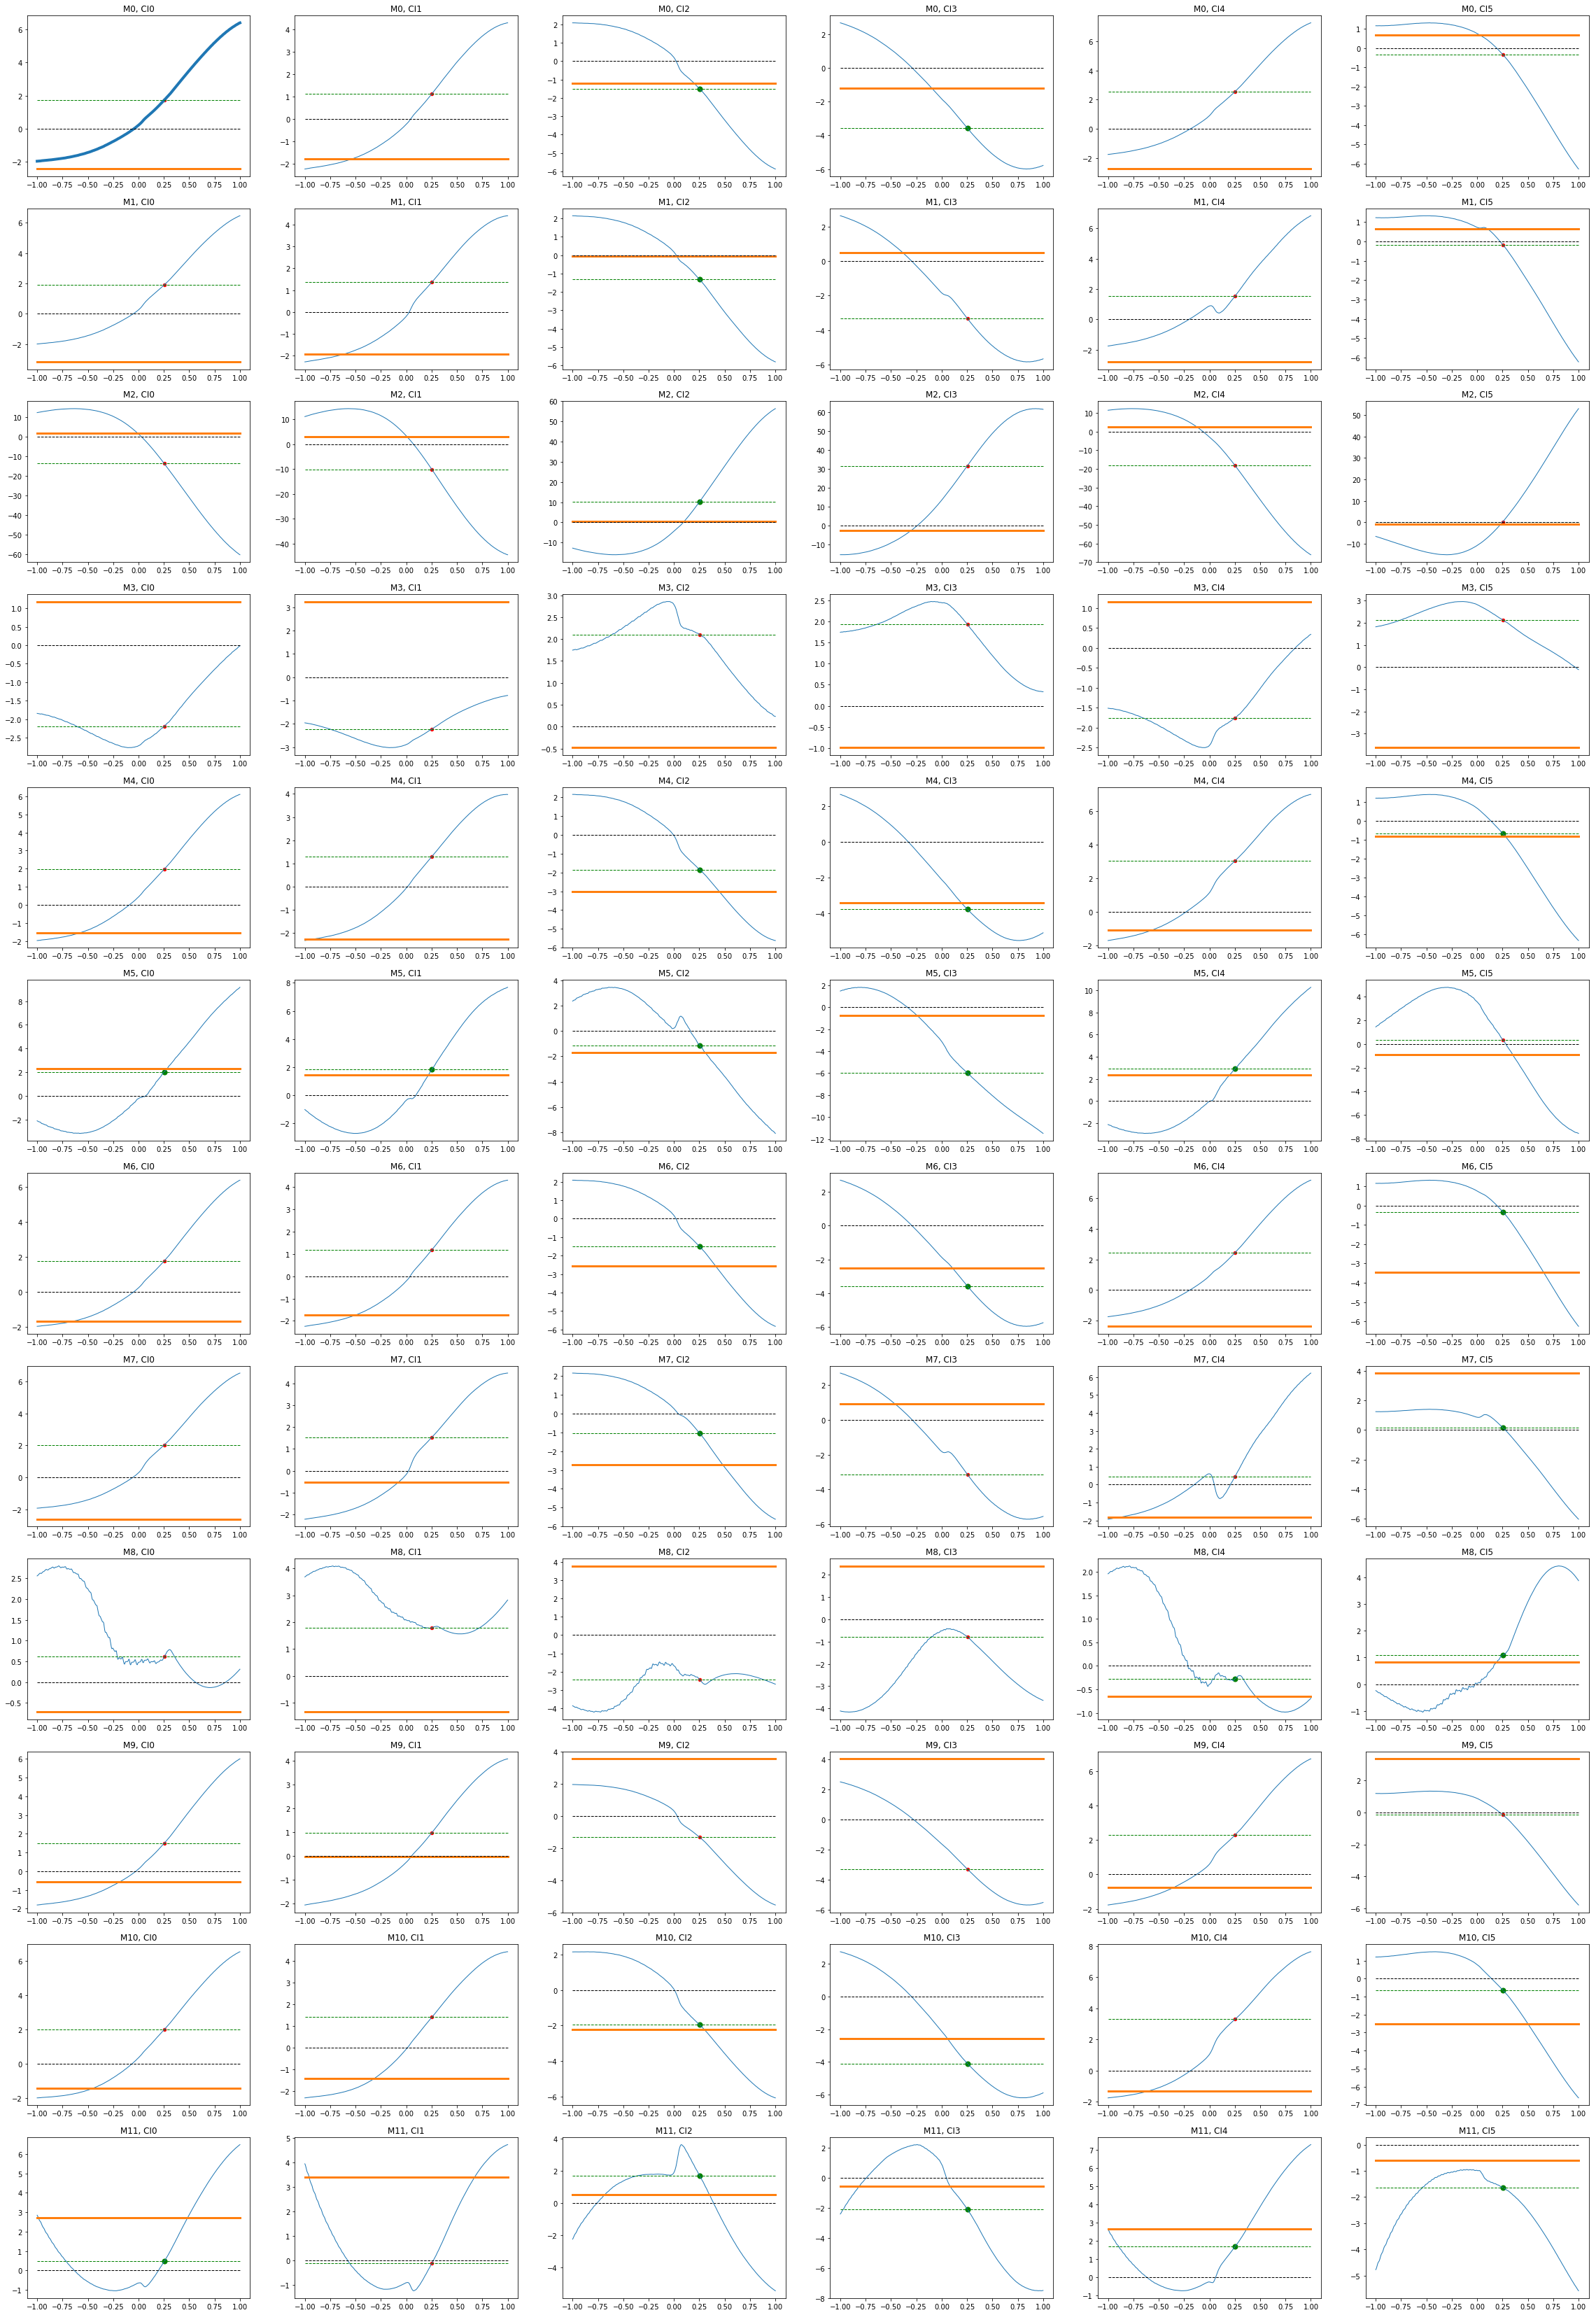

[[0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 0. 1.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 1. 1.]]
[2. 1. 9. 6. 3. 6.]
[2. 1. 1. 0. 3. 5. 3. 2. 2. 0. 3. 5.]
0.375
normalized M__CI correlation weight matrix:
[[ 0.11507895, 0.10037362, -0.12930231, -0.10586781, 0.13027451, -0.1061164, ]
, [ 0.12768268, 0.12163942, -0.11382177, -0.09862497, 0.07847843, -0.05347479]
, [-0.92230143, -0.90512278, 0.87951265, 0.9398487, -0.92614807, 0.07077234]
, [-0.14639329, -0.19632906, 0.17997522, 0.0570919, -0.08926265, 0.68218026]
, [ 0.13170081, 0.11527661, -0.15775553, -0.11218854, 0.15472021, -0.21871071]
, [ 0.13531788, 0.16113176, -0.09645775, -0.17741385, 0.14848065, 0.11323183]
, [ 0.11855507, 0.10504803, -0.12946506, -0.10574413, 0.1241506, -0.10183792]
, [ 0.13534899, 0.13620232, -0.08943573, -0.09292251, 0.02369934, 0.04914523]
, [ 0.04087895

In [16]:
# ANALYSIS OF CORRELATIONS BETWEEN MOTOR UNITS, CI

CID = data[CI, center_idx-C_span:center_idx+C_span].transpose()
CID_diff = np.gradient(CID, axis=0) / net.min_delay
CID_diff_means = np.tile(np.mean(CID_diff, axis=1), (6,1)).transpose()
CID_diff_center = CID_diff - CID_diff_means

# plotting the correlation of one signal against all others
M__CI_w = [[syn.w for syn in net.syns[c] if syn.preID in M] for c in CI]
corr_fig, corr_axs = plt.subplots(12, 6, figsize=(40,60))
base_idx = 0 # index for positive Ia afferent for muscle 0
span = min(200, mid)   # span to plot for the correlation
t = np.linspace(-span*net.min_delay, span*net.min_delay, 2*span)
max_c = 50.
min_c = -50.
eqs = np.zeros((12,6))
corr_w = np.zeros((12,6)) # what the weight should be, according to the correlation
des_val_idx = mid + CI_params['custom_inp_del']
for col in range(6):
    for row in range(12):
        cur_idx = 12*col+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        corr = np.correlate(CID_diff_center[:,col], -MD_diff_center[:,row], mode='valid')
        corr_axs[row,col].plot(t, corr[mid-span:mid+span], linewidth=lw)
        #corr_axs[row,col].set_ylim([min_c,max_c])
        corr_w[row,col] = corr[des_val_idx]
        corr_axs[row,col].plot(t, 4.*M__CI_w[col][row]*np.ones(len(t)), linewidth=3)
        corr_axs[row,col].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        x = t[int(len(t)/2)+ CI_params['custom_inp_del']]
        #corr_axs[row,col].plot([x, x], [min_c, max_c], 'g--', linewidth=1)
        corr_axs[row,col].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        corr_axs[row,col].set_title('M' + str(row) + ', CI' + str(col))
        # Finding if weights are following the correlations
        scat_s = 20
        scat_c = 'r'
        if np.sign(M__CI_w[col][row]) == np.sign(corr[des_val_idx]):
            eqs[row,col] = 1.
            scat_s = 50
            scat_c = 'g'
        corr_axs[row,col].scatter([x], [corr[des_val_idx]], s=scat_s, c=scat_c)
plt.show()

# Regarding whether correlations and weights have the same sign
print(eqs)
print(np.sum(eqs, axis=0))
print(np.sum(eqs, axis=1))
print(sum(eqs.flatten())/(12*6))
# Regarding desired weights according to correlations
# normalizing columns of corr_w (weights on the same C unit)
n_corr_w = corr_w / np.linalg.norm(corr_w, axis=0)
print('normalized M__CI correlation weight matrix:')
print(re.sub('\[,', '[', re.sub('\ +', ', ', str(n_corr_w))))

In [10]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[AF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to spinal units")
for idx, syn in enumerate(net.syns[CE[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")


print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
print("-------------------------\n")

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

Connections to motor units
0) AF (1) --> M, w=-0.300000, port=0, plant_out=None
1) AF (2) --> M, w=0.000000, port=0, plant_out=None
2) AF (3) --> M, w=0.000000, port=0, plant_out=None
3) AF (4) --> M, w=0.000000, port=0, plant_out=None
4) AF (5) --> M, w=0.000000, port=0, plant_out=None
5) AF (6) --> M, w=0.000000, port=0, plant_out=None
6) AF (7) --> M, w=0.300000, port=0, plant_out=None
7) AF (8) --> M, w=0.000000, port=0, plant_out=None
8) AF (9) --> M, w=0.000000, port=0, plant_out=None
9) AF (10) --> M, w=0.000000, port=0, plant_out=None
10) AF (11) --> M, w=0.000000, port=0, plant_out=None
11) AF (12) --> M, w=0.000000, port=0, plant_out=None
12) AF (13) --> M, w=0.000000, port=0, plant_out=None
13) AF (14) --> M, w=0.000000, port=0, plant_out=None
14) AF (15) --> M, w=0.000000, port=0, plant_out=None
15) AF (16) --> M, w=0.000000, port=0, plant_out=None
16) AF (17) --> M, w=0.000000, port=0, plant_out=None
17) AF (18) --> M, w=0.000000, port=0, plant_out=None
18) AF (19) --> M, 

In [11]:
AF_M

array([[-0.3, -0.2,  0.1,  0.2, -0.2,  0.1, -0.3, -0.2,  0.1,  0.2, -0.2,
         0.1],
       [ 0. , -0.3,  0.2,  0.1, -0.1,  0. ,  0. , -0.3,  0.2,  0.1, -0.1,
         0. ],
       [ 0. ,  0. , -0.3, -0.2,  0. , -0.1,  0. ,  0. , -0.3, -0.2,  0. ,
        -0.1],
       [ 0. ,  0. ,  0. , -0.3,  0.1, -0.2,  0. ,  0. ,  0. , -0.3,  0.1,
        -0.2],
       [ 0. ,  0. ,  0. ,  0. , -0.3,  0.2,  0. ,  0. ,  0. ,  0. , -0.3,
         0.2],
       [ 0. ,  0. ,  0. ,  0. ,  0. , -0.3,  0. ,  0. ,  0. ,  0. ,  0. ,
        -0.3],
       [ 0.3,  0.2, -0.1, -0.2,  0.2, -0.1,  0.3,  0.2, -0.1, -0.2,  0.2,
        -0.1],
       [ 0. ,  0.3, -0.2, -0.1,  0.1,  0. ,  0. ,  0.3, -0.2, -0.1,  0.1,
         0. ],
       [ 0. ,  0. ,  0.3,  0.2,  0. ,  0.1,  0. ,  0. ,  0.3,  0.2,  0. ,
         0.1],
       [ 0. ,  0. ,  0. ,  0.3, -0.1,  0.2,  0. ,  0. ,  0. ,  0.3, -0.1,
         0.2],
       [ 0. ,  0. ,  0. ,  0. ,  0.3, -0.2,  0. ,  0. ,  0. ,  0. ,  0.3,
        -0.2],
       [ 0. ,  0. ,  

---

In [13]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin
from matplotlib.animation import FuncAnimation

# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
acts = np.array(data[1])
ipx = data[ipx_track]
ipy = data[ipy_track]
ten = arm_activs[:, np.array(range(7, 28, 4))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()
# creating lines and points
line, = ax.plot([], [], 'o-b', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = frame*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    cur_idx = int(cur_time/t_pres) + strt_idx
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 20), init_func=init, blit=True, interval=20)

plt.show()

FigureCanvasNbAgg()

In [18]:
# Cell used to adjust parameters affecting the range of SF values
# corresponding to the various targets

# In the first cell we calculated the AF output for the 8 targets.
# It is in the AF_Ia_II array, which is 8x12
# We reduce AF_Ia_II in three ways: maximum, minimum, and mean for all targets
AF_max = np.max(AF_Ia_II, axis=0)
AF_min = np.min(AF_Ia_II, axis=0)
AF_mean = np.mean(AF_Ia_II, axis=0)
AF_spread = AF_max - AF_min

# We adjust the SF parameters so the mean output averaged over targets is 
# around 0.5,and the spread is around 0.6. One way is to set 
# 1) All AF__SF weights to 1,
# 2) The threshold equal to the AF_mean value
# 3) The slope inversely related to the spread, as in slope = max_slope/(1.+ a*spread)
max_slope = 12.
a = 5.
slopes = max_slope / (1. + a*AF_spread)
print("Recommended AF__SF weights: 1 ", end="\n\n")
print("Recommended SF thresholds: ")
print(AF_mean, end="\n\n")
print("Recommended SF slopes: ")
print(slopes, end="\n\n")


Recommended AF__SF weights: 1 

Recommended SF thresholds: 
[0.03001529 0.13786383 0.         0.         0.00343967 0.03767195
 0.0567503  0.20718729 0.         0.00058732 0.00486774 0.08199382]

Recommended SF slopes: 
[10.41518239  6.87649804 12.         12.         11.12142395  8.50373573
  9.25495692  5.68057896 12.         11.7245553  10.73664572  6.60555036]



In [71]:
# removing feedback to compare with Fink et al.
for uid in CE+CI:
    syn_list = net.syns[uid]
    for syn in syn_list:
        if syn.preID in AF:
            #syn.w = 0.
            syn.alpha = 1.
            syn.normalize = False

In [14]:
# extracting afferent means
Ia_means = np.zeros(6)
II_means = np.zeros(6)
Ib_means = np.zeros(6)
for m in range(6):
    Ia_means[m] = np.mean(arm_activs[:,28+m])
    II_means[m] = np.mean(arm_activs[:,34+m])
    Ib_means[m] = np.mean(arm_activs[:,22+m])
print(Ib_means)
print(Ia_means)
print(II_means)

[0.11129257 0.11266492 0.25588283 0.19827193 0.11278664 0.21231786]
[ 0.15633114  0.16989016  0.06057457  0.04358065  0.25710432 -0.04038134]
[0.36354063 0.30752302 0.18410055 0.19144469 0.43161586 0.06690525]


In [17]:
AFe_avg = np.mean(AFe_data, axis=1)
print(AFe_avg)
AFi_avg = np.mean(AFi_data, axis=1)
print(AFi_avg)

array([0.03866018, 0.00985212, 0.15867804, 0.1198589 , 0.03491514,
       0.02408432, 0.09283194, 0.25340182, 0.0479315 , 0.00811542,
       0.10755497, 0.02747123, 0.14553479, 0.31146217, 0.00901395,
       0.00628233, 0.08948127, 0.02228283])